In [18]:
%matplotlib inline
from pylab import *
from cam import *
from scipy.optimize import curve_fit, leastsq
from scipy.signal import * 
from scipy.signal import fftconvolve
from scipy.ndimage import *
from numpy import fft
from scipy.ndimage import gaussian_filter
import dill
gray()
def fig1(figsize=(8,8)):
    figure(figsize=figsize)
def fig2(figsize=(16,8)):
    figure(figsize=figsize)
def fig3(figsize=(15,8)):
    figure(figsize=figsize)

<Figure size 432x288 with 0 Axes>

# Correct drift xy from BF frames

select the autofocus structure only  

In [2]:
def getdata(i):
    return loadframe(folder+'/BF%d.tiff'%i).data.astype(float)

def myconvolve(im0, im1):
    im0r=(im0-im0.mean())
    im1r=(im1-im1.mean())[::-1, ::-1]
    return fftconvolve(im0r, im1r, mode='same')

def get_shift(im, ref):
    cc = myconvolve(ref, im)
    h,w=im.shape
    yc, xc = h/2.-0.5, w/2.-0.5    
    x,y = np.unravel_index(np.argmax(cc), cc.shape) # find the match
    return x-xc, y-yc

def correct_shift(im, ref):
    dx,dy = get_shift(im, ref)      
    sim=shift(im, (dx,dy), mode='wrap')
    return sim, array([dx,dy])

def get_allshift(fname, imax, s,skip=1):
    '''
    s: slice
    '''

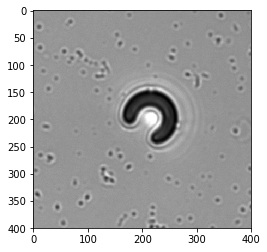

In [3]:
'''
select a square region of interest (roi_shift) that contains a feature
constant during the video (usually is the autofocus structure) 
'''
folder='../dataBF'
im0=getdata(0)
im30=getdata(50)
roi_shift=(slice(350-200, 350+200),slice(1700-200, 1700+200))
#imshow((im30-im0)[s])
imshow(im0[roi_shift])

drift/shift in xy is identified through fft convolution. An array with all the shift position is returned in dr

In [ ]:
max_time=896
dt=1
ref=loadframe(folder+'/BF0.tiff').data[roi_shift].astype(float)
dr=[]
for i in range(0, max_time, dt):
    im=loadframe(folder+'/BF%d.tiff'%i).data[roi_shift].astype(float)
    dr+=[get_shift(im, ref)]
dr= array(dr)
save('dr_shift.npy',dr)

In [ ]:
plot(dr)

# load FL images and correct for shift

In [7]:
max_time=2#it doesnt manage to load all the 820 frames
dt=3
datas=[]
dr=load('dr_shift.npy')
#for i in range(0,max_time,dt)
datas =[shift(loadframe("../dataFL/FL%d.tiff" % i).data.astype(float), (dr[i,0],dr[i,1]), mode='wrap') for i in range(0,max_time,dt)]

In [8]:
dr=load('dr_shift.npy')

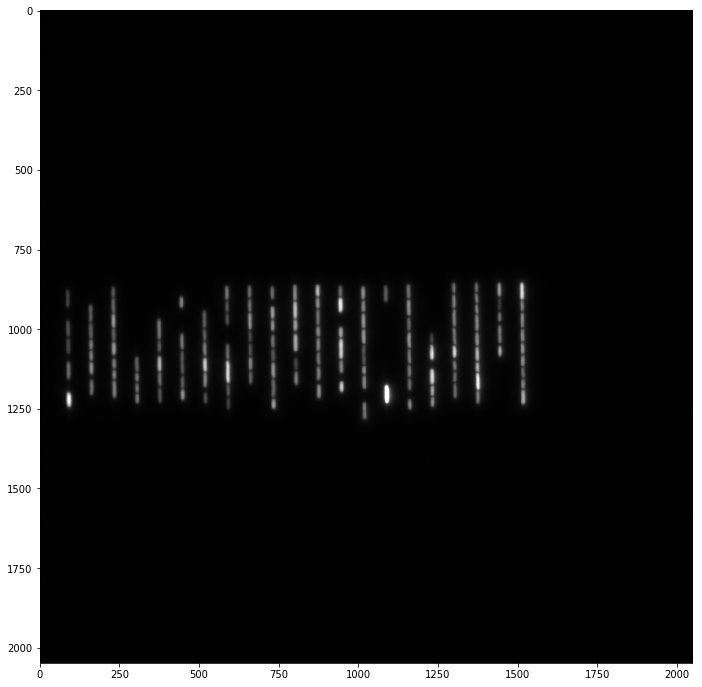

In [9]:
### center the mammastructure
figure(figsize=(12,12))
ymax = 1400
ymin= 750
xmax= 1750
xmin= 0
imshow(datas[0],vmax=10000)

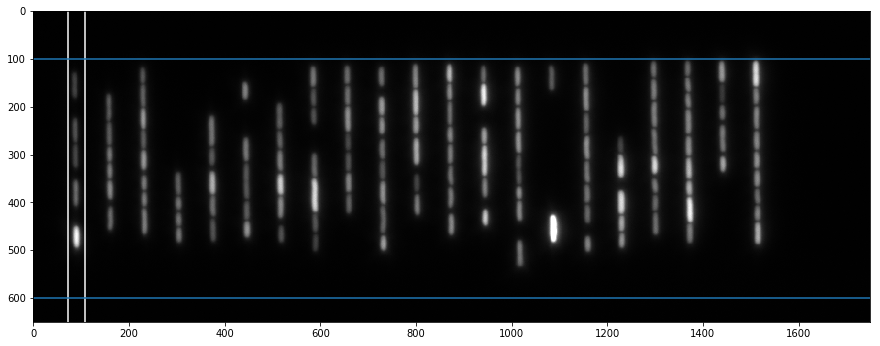

In [10]:
figure(figsize=(15,15))
s = (slice(ymin,ymax), slice(xmin, xmax))
imshow(datas[0][s],vmax=10000)
### now identify a mamma bacteria
#x1= 307;x2= x1+25;
x1= 73;x2= x1+35
y1 = 100; y2= 600;
axvline(x1, color='w')
axvline(x2, color='w')
axhline(y1)
axhline(y2)

# select backgorund on a corner of the frame

(10,)

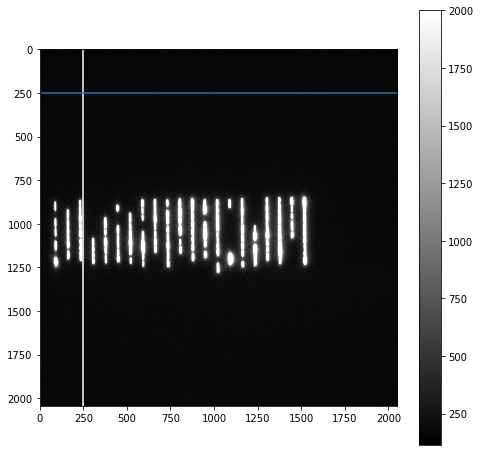

In [11]:
#### select background
figure(figsize=(8,8))
imshow(datas[-1],vmax=2000);colorbar()
x1_bg= 0;x2_bg =250
y1_bg= 0;y2_bg =250
#y1_bg= 1050;y2_bg =1150
#x1_bg= 1250;x2_bg =1500
axvline(x1_bg, color='w')
axvline(x2_bg, color='w')
axhline(y1_bg)
axhline(y2_bg)
bgs=[]
bgs = [(bb[y1_bg:y2_bg,x1_bg:x2_bg]).mean() for bb in datas]
bgs= array(bgs)
(arange(0,10,1)).shape

# Identify all the channel by knowing the channel size and divide all the channel with an ind

71.23076923076923

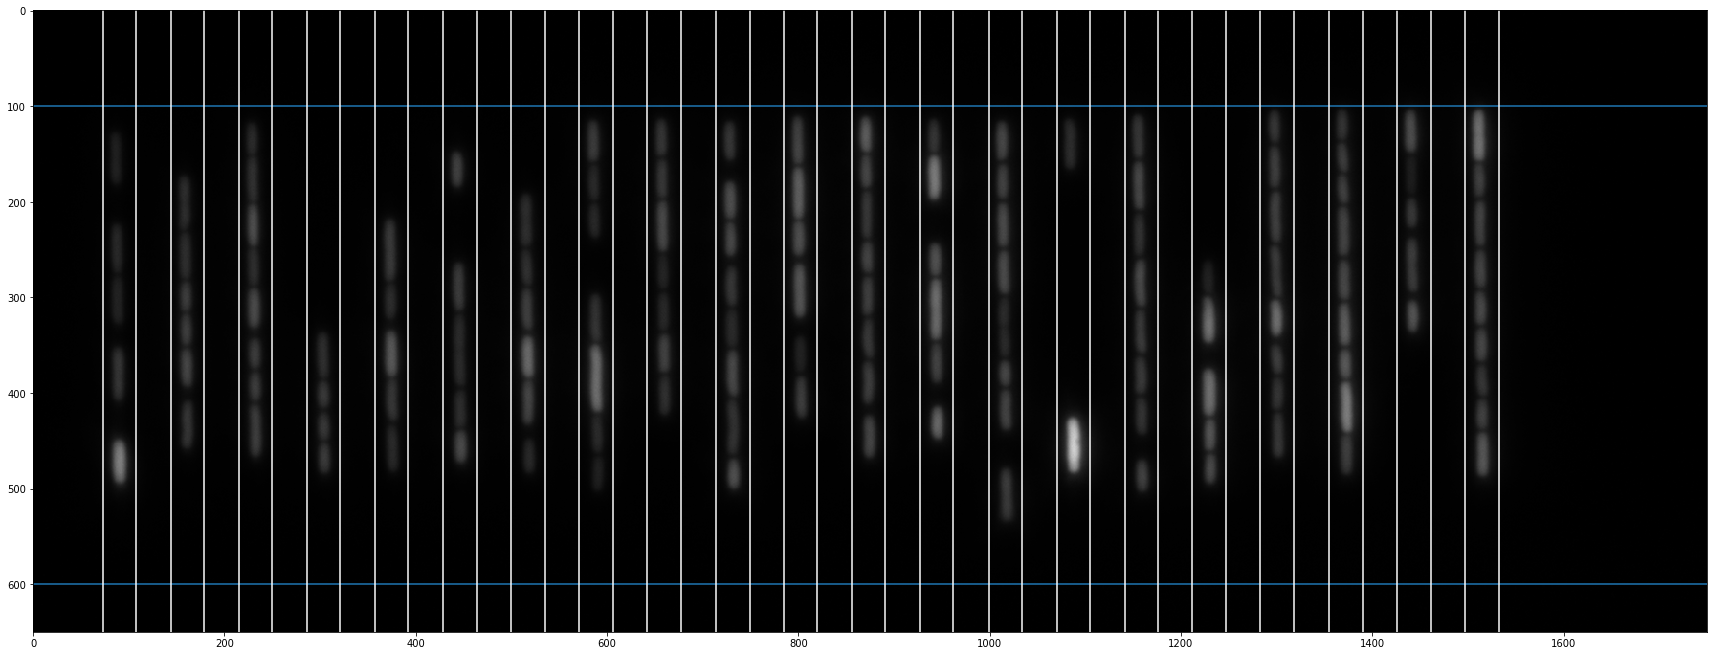

<Figure size 720x720 with 0 Axes>

In [12]:
#### identify all the channel by knowing the channel_size
mpp= 6.5/100 ### for micro camera with 100x
channel_size = (4.63)/mpp  ### teoretical one

N_channels =21;
figure(figsize=(30,30))
imshow(datas[0][s],vmax=20000)
#y1= 45
#y2= 320
axhline(y1)
axhline(y2)
ind= zeros([ymax-ymin,xmax-xmin])
h,w=datas[0][s].shape
x1_ind=[];x2_ind=[];
for i in arange(N_channels):
    x1_temp=uint(x1+(i)*channel_size)
    x2_temp=uint(x2+(i)*channel_size)
    axvline(x1_temp,color='w')
    axvline(x2_temp,color='w')
#    ind[y1:y2,x1_temp:x2_temp]=1 
    x1_ind+=[x1_temp]
    x2_ind+=[x2_temp]
xlim(0,xmax-xmin)
x1_ind=array(x1_ind)
x2_ind=array(x2_ind)
from skimage import measure
ind= measure.label(array(ind))
figure(figsize=(10,10))
#imshow(ind)
channel_size

In [19]:
import pickle
with open('bacteria_shift_indx.pickle','wb') as f:
    pickle.dump([dr,s,N_channels,x1_ind,x2_ind,y1,y2], f)

In [16]:
s

(slice(750, 1400, None), slice(0, 1750, None))

In [ ]:
frames_bacteria=[]
frames_bacteria =[datas[i][s] for i in range(0,len(datas))]

In [ ]:
# save fluodata with shift correction for segmentation
import pickle
with open('bacteria_frames.pickle','wb') as f:
    pickle.dump([frames_bacteria,x1_ind,x2_ind,y1,y2], f)

#  kymograph of a specific channel

In [ ]:
ch_n = 18; ## selected channel

ind_ch = zeros_like(ind)
ind_ch[ind==ch_n]=1  ## ind_ch is the index array for the selected channel
ind_ch=ind_ch.astype('bool')

from scipy.ndimage import gaussian_filter
kymo=[]
N_frames = 80 # normally would be these (arange(0,max_time,dt)).shape[0] , but data after a certain point are crap
for i in range(0,N_frames,1):
    kymo_t = gaussian_filter((datas[i][s][y1:y2-20,x1_ind[ch_n]:x2_ind[ch_n]]).mean(1),3)
    kymo_t = 255*( kymo_t-kymo_t.min())/(kymo_t.max()-kymo_t.min())
    kymo+= [kymo_t]
kymo=array(kymo)
kymo=flip(kymo,0)
figure(figsize=(15,15))
imshow(kymo)
xlabel('Spazio',fontsize=40)
ylabel('Tempo',fontsize=40)
title('Kymograph of 1 channel',fontsize=40)
axvline(80,color='r')
#plot((kymo_t))

# Estimate mamma grow rate for one channel   
(estimating with fourier analysis and intensity peaks difference) 



In [ ]:
### plot the vertical line (time) over the kymograph (with gaussian smoothing)
x=gaussian_filter(kymo[:,80],2.5)
t= arange(0,x.shape[0])*dt
figure();plot(t,x);xlabel('time');ylabel('px intensity normalised'); title('kymograph for the mamma along time')
localmin= argrelextrema(-x, np.greater)
plot(t[localmin],x[localmin],'o')
division_time = (diff(t[localmin])).mean()

### find the division time with a fft of this signal

sp = abs(fft.fft( (x -x.mean()) ) )
freq = fft.fftfreq(t.shape[-1],dt)
figure(); plot(freq[0:t.shape[-1]/2] ,(sp[0:t.shape[-1]/2]),'-o');
xlabel('frequency[1/min]');ylabel('power spectra');title('power spectra kymo' )
avoid_point= 2
ind_max=argmax(sp[avoid_point:t.shape[-1]/2])
plot(freq[ind_max+avoid_point],sp[ind_max+avoid_point],'o')
print('division time from fft %0.2f min' %(1/freq[ind_max+avoid_point]) )
print('division time from findmean %0.2f min' %(division_time) )




# find division time for all the channels, calculate kymograph for each channel and then a division time

In [ ]:
div_times=[];div_times_fft=[]

for ch_n in arange(0,N_channels):
    kymo=[]
    N_frames = 80 # normally would be these (arange(0,max_time,dt)).shape[0] , but data after a certain point are crap
    for i in range(0,N_frames,1):
        kymo_t = gaussian_filter((datas[i][s][y1:y2-20,x1_ind[ch_n]:x2_ind[ch_n]]).mean(1),3)
        kymo_t = 255*( kymo_t-kymo_t.min())/(kymo_t.max()-kymo_t.min())
        kymo+= [kymo_t]
    kymo=array(kymo)
    kymo=flip(kymo,0)
    x=gaussian_filter(kymo[:,80],2.5)
    t= arange(0,x.shape[0])*dt
    localmin= argrelextrema(-x, np.greater)
    division_time = (diff(t[localmin])).mean()

    ### find the division time with a fft of this signal
#    window = hanning(x.shape[0])
    sp = (abs(fft.fft(x -x.mean())))
#    sp = abs(fft.fft( (x -x.mean())*window ) )
    freq = fft.fftfreq(t.shape[-1],dt)
    avoid_point= 3
    ind_max=argmax(sp[avoid_point:t.shape[-1]/2])
    div_times_fft+= [ 1/freq[ind_max+avoid_point] ] 
    div_times+= [division_time]
    
div_times=array(div_times)
div_times_fft=array(div_times_fft)

print('average division time %.2f min'%(div_times[~isnan(div_times)]).mean())
print('average division time from fft %.2f min' %(div_times_fft[~isnan(div_times_fft)]).mean())

# Division time for each channel   
peaks estimation

In [ ]:
div_times

fft estimation

In [ ]:
div_times_fft

In [ ]:
figure();plot(div_times,'ro-');plot(div_times_fft,'ko-');
xlabel('channel number');
ylabel('division time');
title('estimated division time for each channel');
label('peak diff','fft')

# make a movie

In [ ]:
#### make video 
#from makevideo import *
#makevideo_stack(data_movie,100,'test',imin=0,fps=10,fskip=1,vmin=1400,vmax=500,gamma=1.)
#makevideo_stack(datas[:][s],Nframes,'test',imin=0,fps=24,fskip=3,vmin=100,vmax=3000,gamma=1.)
#max_time=500#900
#dt=5
#data_movie =[loadframe("data/FL%d.tiff" % i).data.astype(float)[s] for i in range(0,max_time,dt)]
#from makevideo import *


# plot average intensity over time of mamma only

In [ ]:
#### measure the average intensity of mammas
#ind2= [bool(bb) for bb in ind]
I_mamma=[]
N_frames = 80 # normally would be these (arange(0,max_time,dt)).shape[0] , but data after a certain point are crap
for i in arange(N_frames):
    I_mamma_temp=[]
    I_mamma_temp+=[(datas[i][s][y1:y1+80, x1_ind[ch_n]:x2_ind[ch_n]]).mean() for ch_n in arange(N_channels)]
    I_mamma+=[array(I_mamma_temp)]
I_mamma = array(I_mamma).mean(1)
I_mamma = array(I_mamma) #- bgs; 

In [ ]:
### plot intensity over time and fit with exponential decay
figure(figsize=(8,8))
t=arange(0,80*3,dt)
plot(t[0:80],I_mamma[0:80],'.')

def expofit(x, A, tau, bg):
    return A*exp(-x/tau)+bg
p0=[10000,60,2000]
     
p,dp=curve_fit(expofit, t[0:80], I_mamma[0:80], p0=p0)
A, tau,bg=p
plot(t, expofit(t,  A, tau,bg))

# Estimating decaying time for protein concentration

Let's write the following equation for the protein concentration within a cell
$$\dot{p}= \alpha - \gamma p - \mu p $$
where $p$ is the protein concentration, $\alpha$ the protein production rate, $\gamma$ is the protein degration rate, $\mu$ the dilution factor, reletated to the growth rate $\dot{V}= \mu V$ where $V$ is the volume of the cell. We can express $\mu$ in terms of the doubling time $\tau_d= ln{2}/\mu$. 


In [ ]:
doubling_time = (div_times[~isnan(div_times)]).mean() ## estimated from kymographs
mu = log(2)/doubling_time ### [1/min]
#mu = 1/(doubling_time*log2(e))
print ('dilution factor %0.3f [1/min]'%mu)

If we include also bleaching rate $\beta$ the latter equation become:
$$\dot{p}= \alpha - \gamma p - \mu p - \beta p$$
Then, when we add the bleachin effect we expect the protein concentration to decrease exponentially such that:
$$p = (\overline{p}_{1}- \overline{p}_{2}) e^{-t/\tau}+ \overline{p}_{2}$$  
where $$ \tau = \frac{1}{\gamma + \mu + \beta}$$
The bleaching rate was previously estimated to be:
$$ \beta=0.025\;[1/\mathrm{frames}] $$
For an experiment were frames are taken every 180 s, we find $$ \beta_{2}=0.025/180~[1/min] $$

In [ ]:
beta_frames= 0.025
beta = beta_frames/180 #### [1/min]
print ('bleaching factor %0.4f [1/min]'%beta)

If we neglect the protein degradation, we then expect that the observed decay time should be $$ \tau = \frac{1}{\mu + \beta}$$

In [ ]:
tau_th = 1/(beta+mu)
print ('The theoretical decay time is %0.2f [1/min]'%tau_th)
print ('The measured decay time is %0.2f [1/min]'%tau)

the protein degradation factor should be 
$$\gamma= \frac{1}{\tau}-(\mu + \beta)$$
where $\beta$, the bleachin rate, it was estimated from the bleaching experiment and $\mu$ should be the dilution factor 

In [ ]:
gamma=1/tau - beta - mu
print ('Estimated protein degradation rate %0.4f [1/min]'%gamma)

# Analysis is up to here: 
the rest is from old files an attempt to SEGMENTATION

# segmentation attempt with MMhelper (Smith 2019, Scientific reports) 

In [ ]:
import skimage.measure as skmeas
from skimage.morphology import watershed, medial_axis, skeletonize
from skimage.filters import sobel
import skimage.filters as skfilt
from skimage.measure import regionprops
import skimage.morphology as skmorph
import skimage.segmentation as skseg
import scipy.ndimage as ndi

In [ ]:
def remove_background(profiles, radius=20, light_background=True):
    """
    Uses port of ImageJ rolling ball background subtraction
    to estimate background and removes the background from the image

    Parameters
    ------
    profiles : Dictionary
        Key is the well number and the value is a ndarray (2D) of the well
    radius : float, optional
        The radius of the rolling ball (default : 20)
    light_background : Boolean
        Whether the background is light or not (default : True)

    Returns
    ------
    newprofiles : Dictionary
        Key is the well number and the value is a ndarray (2D) of the
        background subtracted well
    """
    # Make "spherical" structuring element
    sz_ = 2 * radius + (radius + 1) % 2
    xco, yco = np.meshgrid(range(sz_), range(sz_))
    ballheight = float(radius**2) - (xco - radius)**2 - (yco - radius)**2
    ballheight[ballheight < 0] = 0
    ballheight = np.ma.masked_where(ballheight < 0, ballheight)
    ballheight = np.sqrt(ballheight)
    newprofiles = {}
    for k, im1 in profiles.items():
        im1=-im1;
        # Run background subtraction
        if light_background:
            imax = im1.max()
            im2 = imax - im1
            bg1 = ndi.grey_opening(im2, structure=ballheight, mode="reflect")
            im2 -= bg1
            newprofiles[k] = im2 - imax
        else:
            bg1 = ndi.grey_opening(im1, structure=ballheight, mode="reflect")
            newprofiles[k] = bg1 - im1
    return newprofiles

def split_bacteria_in_all_wells(
        bacteria,
        well_images,
        #min_break_size=2,
        min_skel_length=50,
    ):
    """
    Takes a dictionary containing a labelled image of detected bacteria
    and attempts to 'split' any labels which may have been detected as
    multiple bacteria instead of one

    Parameters
    ------
    bacteria : Dictionary
        The key is the well coordinates and the value is a labelled image of detected bacteria
    well_images : Dictionary
        Key is the well number and the value is a ndarray (2D) of the well

    returns
    ------
    split_bac : Dictionary
        The key is the well coordinates and the value is a labelled image of detected bacteria
    """
    dists = []
    intensities = []
    for well_label, bacteria_label_image in bacteria.items():
        # this function return the intensity and distances(form background) of pixels of the skeleton of long bacteria 
        distnow, intnow = get_bacteria_stats_in_well(
            bacteria_label_image,
            well_images[well_label],
            min_skel_length=min_skel_length
        )
        dists.extend(distnow) # append all from all the wells
        intensities.extend(intnow)

    dists = np.array(dists)
    intensities = np.array(intensities)
    import matplotlib.pyplot as plt

    iqr25, iqr75 = np.percentile(dists, [25, 75])
    dists2 = dists[(dists>=iqr25) & (dists<=iqr75)]  # remove skel distances outside the percentile
    iqr25, iqr75 = np.percentile(intensities, [25, 75])
    intensities2 = intensities[(intensities>=iqr25) & (intensities<=iqr75)] # remove skel intesity outside the percentile

    medd, madd = get_med_and_mad(dists)
    medd2, madd2 = get_med_and_mad(dists2)
    medi, madi = get_med_and_mad(intensities)
    medi2, madi2 = get_med_and_mad(intensities2)

    plt.show()

    for well_label, bacteria_label_image in bacteria.items():
        newbacteria = split_bacteria_in_well(
            bacteria_label_image,
            well_images[well_label],
            min_skel_length=min_skel_length,
            threshold_stat=medd2-madd2,# this is the threshold distance obtained from all the wells
            debug=dict(
                med_dist=medd, mad_dist=madd,
                med_dist2=medd2, mad_dist2=madd2,
                med_int=medi, mad_int=madi,
                med_int2=medi2, mad_int2=madi2,
            )
        )
        bacteria[well_label] = newbacteria
    return bacteria


def get_med_and_mad(data):
    """
    Return median and MAD of data
    """
    med = np.median(data)
    mad = np.median(np.abs(data - med))
    return med, mad


def threshold_mad(data, factor):
    """
    Determine Median Absolute Deviation based threshold
    """
    med, mad = get_med_and_mad(data)
    threshold = med - factor * mad
    return threshold


def get_bacteria_stats_in_well(
        bacteria_label_image,
        intensity_image,
        min_skel_length=50,
    ):
    """
    Get bacteria width stats in a single well image using
    distance transform and skeletonization

    Parameters
    ------
    bacteria_label_image : ndarray (2D)
        Labelled image of detected bacteria
    intensity_image : ndarray (2D)
        Intensity image for the current well
    min_skel_length : float (optional)
        Minimum skeleton length for a region to be considered for splitting
    returns
    ------
    split_bac : Dictionary
        The key is the well coordinates and the value is a labelled image of detected bacteria
    """
    mask = bacteria_label_image > 0
    dist = ndi.distance_transform_edt(mask)
    skel = skmorph.skeletonize(mask)
    skellabel = ndi.label(skel)[0]
    for prop in regionprops(skellabel):
        if prop.area < min_skel_length:
            skel[skellabel == prop.label] = False
        #skelmask = skellabel == prop.label

    return dist[skel], intensity_image[skel]


def split_bacteria_in_well(
        bacteria_label_image,
        intensity_image,
        min_skel_length=50,
        threshold_stat=None,
        debug=None,
    ):
    """
    Split bacteria in a single well image based on
    statistical thresholding of width and intensity along
    the skeleton

    Parameters
    ------
    bacteria_label_image : ndarray (2D)
        Labelled image of detected bacteria
    intensity_image : ndarray (2d)
        Intensity image of current well
    min_skel_length : float (optional)
        Minimum skeleton length for a region to be considered for splitting
    returns
    ------
    split_bac : Dictionary
        The key is the well coordinates and the value is a labelled image of detected bacteria
    """

    max_label = 0
    stats = []
    dist = ndi.distance_transform_edt(bacteria_label_image > 0)
    output_labels = bacteria_label_image.copy()
    for prop in regionprops(bacteria_label_image):
        region_mask = bacteria_label_image == prop.label
        #skel, dist = skmorph.medial_axis(region_mask, return_distance=True)
        skel = skmorph.skeletonize(region_mask)
        if skel.sum() < min_skel_length:
            max_label += 1
            output_labels[region_mask] = max_label
            continue

        skelprop = regionprops(skel.astype(int))[0]
        posy, posx = skelprop.coords.T

        skel_intensity = intensity_image[skel]
        skel_dist = dist[skel]

        threshold_int = threshold_mad(skel_intensity, 2)
        threshold_dist = threshold_mad(skel_dist, 1)

        inds = np.argsort(posy)
        for i, (name, vals, name2) in enumerate((
                ("Distance", skel_dist, "dist"),
                ("Intensity", skel_intensity, "int"),
                ("Combined", skel_dist*(-1*skel_intensity), None),
                )):
            med, mad = get_med_and_mad(vals)

        breaks = skel_intensity < (debug["med_int"] - debug["mad_int"])#threshold_int

        breaks_dist = skel_dist < debug["med_dist"] #threshold_dist
        #breaks_dist = skel_dist < np.median(skel_dist) #debug["med_dist"] #threshold_dist

        skel_dist_breaks = skel.copy()
        skel_dist_breaks[skel] = breaks_dist

        breaks[~breaks_dist] = False

        ### TODO: added this in as potential width ratio method
        ### neeed to rethink with Jeremy
        #width_ratio = 0.5
        #threshold_dist_ratio = width_ratio * np.max(skel_dist)
        #threshold_dist_ratio = np.median(skel_dist) - 1*threshold_stat
        threshold_dist_ratio = threshold_stat


        breaks_dist_hard = skel_dist < threshold_dist_ratio
        #breaks[breaks_dist_hard] = True

        skel_breaks = skel.copy()
        skel_breaks[skel] = breaks

        break_labels, n_breaks = ndi.label(skel_breaks)

        sizes = ndi.sum(
            skel_breaks, break_labels,
            index=np.arange(1, n_breaks + 1)
        )
        for label, break_size in enumerate(sizes, start=1):
            # if break_size < min_break_size:
            if break_size < 0:
                skel_breaks[break_labels == label] = False
        bacteria_markers, n_bacteria_markers = ndi.label(
            skel ^ skel_breaks,
            structure=np.ones((3, 3), dtype=bool)
            )

        num_removed = 0
        for label in range(1, n_bacteria_markers+1):
            bwnow = bacteria_markers == label
            if bwnow.sum() >= min_skel_length:
                continue
            bacteria_markers[bwnow] = 0
            num_removed += 1

        if num_removed == n_bacteria_markers:
            max_label += 1
            output_labels[region_mask] = max_label
            continue


        bacteria_markers, num_final = ndi.label(
            bacteria_markers>0,
            structure=np.ones((3,3), dtype=bool)
        )

        bacterianow = watershed(-dist, bacteria_markers, mask=region_mask)
        bacterianow[bacterianow > 0] += max_label
        output_labels[region_mask] = bacterianow[region_mask]
        max_label += num_final

    return output_labels


def relabel_bacteria(bacteria):
    """
    Relabel bacteria in dictionary to be
    sequential
    """
    relabelled = {}
    maxlabel = 0
    for well_label, bacnow in bacteria.items():
        bacnow[bacnow > 0] += maxlabel
        relabelled[well_label] = bacnow.copy()
        maxlabel = max(maxlabel, bacnow.max())
    return relabelled



In [ ]:
def channel_gaussian_laplace(channel_images):
#    scale-space filter of the images in the channel. 
#    using a Laplace of Gaussian convolution at multiple scales, and maximum-projected along the scale axis 

#    sigma_list=(2., 6.),
    sigma_list = np.arange(2.,6.)    
    segs = {}  # here images after hessian filter   

    for ch_n,im_channel in channel_images.items():
        gl_images = [-(ndi.gaussian_laplace(im_channel, ss, mode="nearest")) * ss ** 2
                     for ss in sigma_list]
        newwell = np.max(gl_images, axis=0)
        segs[ch_n] = newwell
    return segs

def bacteria_watershed(
    segs,
    maxsize=1000, #uint16((5*2)/(pix2mic**2))  ### max area
    minsize=200, #uint16((0.5*0.1)/(pix2mic**2))    ### min area
    absolwidth=1,
    ):
    
    print maxsize
    print minsize
 
    segs2 = {} # here images after watershed
    thresh_array=[];
    for ch_n, img0 in segs.items():
        
        thresh_array.append(skfilt.threshold_minimum(img0.flatten()))
        bw0 = img0 > skfilt.threshold_minimum(img0.flatten());
        bw1 = ndi.morphology.binary_erosion(bw0)
        bw2 = ndi.morphology.binary_dilation(bw0)
        bw3 = bw2 ^ bw1; ### only the borders
        # perform distance transform on filtered image (distance from the nearest 0)
        dist = ndi.distance_transform_edt(bw1)
        markers = np.zeros(img0.shape, dtype=bool)
        markers[dist >= absolwidth] = True
        markers = ndi.label(markers)[0]
        markers = markers + 1
#    bw3 = bw2 ^ (dist >= absolwidth); ### only the borders
        markers[bw3] = 0

        # Perform watershed
        # edit by Nicola
        segmentation = watershed(-img0, markers) 
    #    segmentation = watershed(img0, markers) 
        segmentation = ndi.binary_fill_holes(segmentation != 1)

        # label image
        labeled_bacteria, nbac = ndi.label(segmentation)

        ### now filter bacteria for size and width
        dist = ndi.distance_transform_edt(labeled_bacteria > 0)

        newbac = np.zeros(labeled_bacteria.shape, dtype=labeled_bacteria.dtype)

        stats = dict(
            num_rejected_av_width=0,
            num_rejected_area=0,
        )

        label = 0
        for region in regionprops(labeled_bacteria):
            masked_bac = labeled_bacteria == region.label
            skel = skeletonize(masked_bac)
            av_width_skel = np.mean(dist[skel])
            if av_width_skel < min_av_width:
                stats["num_rejected_av_width"] += 1
                continue
            if maxsize > region.area > minsize:
                label += 1
                newbac[labeled_bacteria == region.label] = label
            else:
                stats["num_rejected_area"] += 1

        segs2[ch_n] = newbac
    return segs2,thresh_array


# test to optimise segmentation

In [ ]:
from copy import deepcopy

i=1;

channel_images_raw = {}
for ch_n in arange(0,N_channels-1):
    channel_images_raw[ch_n] = datas[i][s][y1:y2,x1_ind[ch_n]:x2_ind[ch_n]]
    
# remove background from each well using a rollball method. To check.
channel_images= remove_background(channel_images_raw, radius=20, light_background=True)

pix2mic=6.5/100.    

min_av_width=1#uint16(0.1/pix2mic) ### minimum width of a bacteria    
maxsize=6000#uint16((5*2)/(pix2mic**2))  ### max area    
minsize=150#uint16((0.5*0.1)/(pix2mic**2))    ### min area

absolwidth=1    
sigma_list=(2., 6.); 
sigma_list = np.arange(*sigma_list)    
segs = {}  # here images after hessian filter    
segs2 = {} # here images after watershed

# scale-space filter of the images in the channel. 
#using a Laplace of Gaussian convolution at multiple scales, and maximum-projected along the scale axis 
for ch_n,im_channel in channel_images.items():
    gl_images = [-(ndi.gaussian_laplace(im_channel, ss, mode="nearest")) * ss ** 2
                     for ss in sigma_list]
    newwell = np.max(gl_images, axis=0)
    segs[ch_n] = newwell

# threshold value is determined using Li’s algorithm to avoid over-segmentation of empty channels.
# I removed this step. Using a different threshold method (skfilt.threshold_minimum) 
#thresh = skfilt.threshold_li(np.concatenate(
#        [ss.flatten() for ss in segs.values()]))

ch_n=1;
absolwidth=1
figure(figsize=(10,10))
#ch_n = 0
#img0=segs[ch_n]
#for ch_n in arange(1,2):
img0=segs[ch_n]
subplot(1,6,1);
imshow(img0),axis('off'); 
#    thresh = threshold_li_smith(img0.flatten())
thresh = skfilt.threshold_minimum(img0.flatten())
#    thresh = skfilt.threshold_li(img0.flatten())
bw0 = img0 > thresh;
subplot(1,6,2);axis('off');
imshow(bw0)
bw1 = ndi.morphology.binary_erosion(bw0,structure=np.ones((1,1)),iterations=1)
subplot(1,6,3);axis('off');
imshow(bw1)
bw2 = ndi.morphology.binary_dilation(bw0)
bw3 = bw2 ^ bw1; ### only the borders
# perform distance transform on filtered image (distance from the nearest 0)
dist = ndi.distance_transform_edt(bw1)
#    bw3 = bw2 ^ (dist >= absolwidth); ### only the borders
markers = np.zeros(img0.shape, dtype=bool)
markers[dist >= absolwidth] = True
markers = ndi.label(markers)[0]
markers = markers + 1
markers[bw3] = 0
subplot(1,6,4);axis('off');
imshow(markers)

segmentation = watershed(-img0, markers) 
#    segmentation = watershed(img0, markers) 
segmentation = ndi.binary_fill_holes(segmentation !=1)

# label image
labeled_bacteria, nbac = ndi.label(segmentation)

### now filter bacteria for size and width
dist = ndi.distance_transform_edt(labeled_bacteria > 0)
subplot(1,6,5);axis('off');
imshow(labeled_bacteria)

newbac = np.zeros(labeled_bacteria.shape, dtype=labeled_bacteria.dtype)

stats = dict(
    num_rejected_av_width=0,
    num_rejected_area=0,
)

label = 0
for region in regionprops(labeled_bacteria):
    masked_bac = labeled_bacteria == region.label
    skel = skeletonize(masked_bac)
    av_width_skel = np.mean(dist[skel])
    if av_width_skel < min_av_width:
        stats["num_rejected_av_width"] += 1
        continue
    if maxsize > region.area > minsize:
        label += 1
        newbac[labeled_bacteria == region.label] = label
    else:
        stats["num_rejected_area"] += 1

subplot(1,6,6);axis('off');
imshow(newbac)
bacteria_label_image = deepcopy(newbac)


## run the same but with the functions

#### single time bacteria segmentation
from copy import deepcopy
    
#min_skel_length=5,

segs = channel_gaussian_laplace(channel_images)
segs2,thresh_array = bacteria_watershed(segs,maxsize=maxsize,minsize=minsize)
unlabelled_bacteria = split_bacteria_in_all_wells(segs2, channel_images,min_skel_length=50)
bacteria = relabel_bacteria(unlabelled_bacteria)

figure(figsize=(10,10))
subplot(1,2,1);axis('off');imshow(segs2[ch_n])
subplot(1,2,2);axis('off');imshow(bacteria[ch_n])

# end test

In [ ]:
#### single time bacteria segmentation
from copy import deepcopy

i=1;

channel_images_raw = {}
for ch_n in arange(0,N_channels-1):
    channel_images_raw[ch_n] = datas[i][s][y1:(y2),x1_ind[ch_n]:x2_ind[ch_n]]
    
# remove background from each well using a rollball method. To check.
channel_images= remove_background(channel_images_raw, radius=20, light_background=True)

    
#min_skel_length=5,
segs = channel_gaussian_laplace(channel_images)
segs2,thresh_array = bacteria_watershed(segs,maxsize=6000,minsize=150)
unlabelled_bacteria = split_bacteria_in_all_wells(segs2, channel_images,min_skel_length=50)
bacteria = relabel_bacteria(unlabelled_bacteria)

In [ ]:
figure(figsize=(10,10))
k=1
subplot(151);imshow(channel_images_raw[k]);
subplot(152);imshow(channel_images[k]);
subplot(153);imshow(segs[k]);
subplot(154);imshow(segs2[k],cmap='plasma');colorbar()
subplot(155);imshow(bacteria[k],cmap='plasma');colorbar()
channel_images[k].min()



# Bacteria Tracking 

In [ ]:
### functions from Smith2019Scientific_Reports

from functools import reduce
from skimage.measure import regionprops
import numpy as np

import tempfile
import os
import itertools
from skimage.feature import (
    match_descriptors,
    plot_matches,
    ORB,
    match_template,
)
import skimage.util as skutil
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage.measure import regionprops
import numpy as np
#from mmhelper.utility import logger
#import mmhelper.bacteria_tracking as bactrack
import matplotlib.pyplot as plt
import pdb



def bacteria_tracking(last_wells, current_wells, bacteria_lineage,
                    prob_div=0.3,
                    prob_death=0.01,
                    prob_no_change=0.7,
                    av_bac_length=40,#18,                                                               
                    ):
    """
    Takes a dictionary of wells from the previous frame and a second
    dictionary with the corresponding wells for the new frame and
    determines the most likely way the bacteria within them have
    moved, died, divided then relabels them accordingly

    Parameters
    ------
    last_wells : Dictionary
        The previous timepoint. The key is the well coordinates and the value
        is a labelled image of detected bacteria
    current_wells : Dictionary
        The current timepoint. The key is the well coordinates and the value
        is a labelled image of detected bacteria
    bacteria_lineage : dictionary
        A dictionary that links the physical unique label of a bacteria
        to one which shows information on its lineage

    Returns
    ------
    out_wells : Dictionary
        The current timepoint. The key is the well coordinates and the value
        is a labelled image of tracked bacteria
    bacteria_lineage : dictionary
        Updated dictionary that links the physical unique label of a bacteria
        to one which shows information on its lineage
    """
    out_wells = {}
    for num, well in last_wells.items():

        if num not in current_wells.keys():
            continue
        new_well = current_wells[num]
        in_list = []
        #option_list = []
        for region in regionprops(well):
            # list the bacteria labels from the current frame
            in_list.append(region.label)
        # create a list of all the possible combinations
#        logger.debug("Creating combination of %d items repeated %d times" % (
#            len(in_list), len(regionprops(new_well))))
        options = itertools.combinations_with_replacement(
            in_list, len(regionprops(new_well)))

        if not in_list:
            if len(regionprops(new_well)) > 0:
                # if there is now a new bacteria we don't want to ignore as it may have just
                # been missed in previous frame
                smax = max(bacteria_lineage, key=int)
                newwell = np.zeros(new_well.shape, dtype=new_well.dtype)
                for new_bac in regionprops(new_well):
                    # so lets give each "new" bacteria a new label
                    smax += 1
                    newwell[new_well == new_bac.label] = smax
                    bacteria_lineage[smax] = str(smax)
            elif not next(options, None):
                # if the out well is also empty then there is nothing to track
                # and simply return an empty well
                newwell = np.zeros(new_well.shape, dtype=new_well.dtype)
        else:  # determine probabilities and label matching/new bacteria
            #options_dict[n] = [in_list,option_list]
            change_options = find_changes(
                in_list, options, well, new_well)
            best_option = None
            best_prob = 0
            for option, probs in change_options:
                probs_ = find_probs(probs,
                                    prob_div,
                                    prob_death,
                                    prob_no_change,
                                    av_bac_length,#18,                                   
                                    )
#                pdb.set_trace()
                if probs_ > best_prob:
                    best_prob = probs_
                    best_option = option
            newwell, bacteria_lineage = label_most_likely(
                best_option, new_well, bacteria_lineage)
        out_wells[num] = newwell

    return out_wells, bacteria_lineage

#### Nicola: in this function I had to make arrays of all the list in the sum function
def find_changes(in_list, option_list, well, new_well):
    """
    Takes a list

    Parameters
    ------
    in_list : list
        A list of labels from the current well
    option_list : list
        A list of all the possible combinations possible of how the bacteria
        in the previous well could be in the new well
    well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the old well
    new_well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the new well

    Yields
    ------
    option : list
        Containing the potential output combination
    in_options_dict : dictionary
        where the key is one of the input bacteria labels and the values
        is a list of the number of divisions, area change and centroid change
        for that respective bacteria for that potential output combination
    """
    measurements_in = {}
    measurements_out = {}
    for i, region in enumerate(regionprops(well)):
        # find y centr coord and area of old each bac
        measurements_in[i] = [region.centroid[0], region.area]
    for j, region2 in enumerate(regionprops(new_well)):
        # find y centr coord and area of each new bac
        measurements_out[j] = [region2.centroid[0], region2.area]
    for option in option_list:  # each option is a potential combination of bacteria lineage/death
        in_options_dict = {}
        for in_num, in_options in enumerate(in_list):
            out_bac_area = []
            out_bac_centr = []
            # determine the number of divisions/deaths
            num_divs = (option.count(in_options)) - 1
            for lst, opt in enumerate(option):
                if opt == in_options:  # if the values match append the new centr/areas
                    out_bac_area.append(measurements_out[lst][1])
                    out_bac_centr.append(measurements_out[lst][0])
            # need to divide by biggest number (so prob < 1)
            if sum(array(out_bac_area)) < (measurements_in[in_num][1]):
                # find relative change in area compared to original
                area_chan = float(sum(array(out_bac_area))) / (measurements_in[in_num][1])
            else:
                # find relative change in area compared to original
                area_chan = (measurements_in[in_num][1]) / float(sum(array(out_bac_area)))
            if len(out_bac_centr) is not 0:
                # find the average new centroid
                centr_chan = abs((float((sum(array(out_bac_centr)))) / (len(out_bac_centr)))
                                 - (measurements_in[in_num][0]))
            else:
                centr_chan = 0
            # assign the values to the correct 'in' label
            in_options_dict[in_options] = [num_divs, area_chan, centr_chan]
        # change_dict[option] = in_options_dict #assign the changes to the
        # respective option
        yield option, in_options_dict  # assign the changes to the respective option
        # return change_dict


def find_probs(
        probs,
        prob_div=0.3,
        prob_death=0.01,
        prob_no_change=0.7,
        av_bac_length=40,#18,
    ):
    """
    Takes a dictionary of information for a potential combination
    and returns an overall probability

    Parameters
    ------
    probs : dictionary
        Key is a unique number of an input bacteria and the value is a
        list of the number of divisions, area change and centroid change
        for that respective bacteria
    prob_div : float, optional
        Probability a bacteria divides between consecutive timepoints (default : 0.01)
    prob_death : float, optional
        Probability a bacteria lyses between consecutive timepoints (default : 0.5)
    prob_no_change : float, optional
        Probability there is no change between consecutive timepoints (default : 0.95)
    av_bac_length : float, optional
        The average bacteria length in pixels (default : 18)

    Returns
    ------
    combined_prob : float
        The overall probability for this combination of events
    """
    probslist = []
    for pro in probs:
        # find the potential number of deaths/divisions for each bac
        divs_deaths = probs[pro][0]
        relative_area = probs[pro][1]  # find the relative area change
        # find the number of pixels the centroid has moved by
        change_centr = probs[pro][2]
        if divs_deaths < 0:  # if the bacteria has died:
            prob_divis = prob_death  # probability simply equals that of death
            prob_centr = 1  # the change in centroid is irrelevant so set probability as 1
            prob_area = 1  # the change in area is irrelevant so set probability as 1
        if divs_deaths == 0:  # if the bacteria hasn't died/or divided
            # probability of division simply equals probability of no change
            prob_divis = prob_no_change
            # the area will be equal to the relative area change - may need
            # adjusting
            prob_area = relative_area
            # if there is no change then set prob to 1 (0 will cause div error)
            if change_centr == 0:
                prob_centr = 1
            else:
                # the greater the change the less likely
                prob_centr = 1 / (abs(change_centr))
        if divs_deaths > 0:  # if bacteria have divided:
            # need to make sure we divide by biggest number to keep prob < 1
            if relative_area < divs_deaths:
                # normalise relative area to the number of divisions
                prob_area = relative_area / divs_deaths
            else:
                # normalise relative area to the number of divisions
                prob_area = divs_deaths / relative_area
            # each division becomes more likely - need to think about it
            prob_divis = prob_div**(divs_deaths * divs_deaths)
            # for each division the bacteria centroid is expected to move half
            # the bac length
            prob_centr = 1 / \
                abs(((divs_deaths * (av_bac_length / 2)) - (change_centr)))
        # combine the probabilities for division, area and centroid
        probslist.append(prob_area * prob_divis * prob_centr)
    # multiply the probabilities across all bacteria
    combined_prob = reduce(lambda x, y: x * y, probslist)
    return combined_prob


def label_most_likely(most_likely, new_well, label_dict_string):
    """
    Takes the most likely combination of how the bacteria may have
    divided/died or moved around and re-labels them accordingly

    Parameters
    ------
    most_likely : list
        Containing the most likely output combination
    new_well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the new well
    label_dict_string : dictionary
        Each key is a unique label of a bacteria, each value is
        a string containing its lineage information

    Returns
    ------
    out_well : ndarray (2D) of dtype int
        A labelled image showing the tracked bacteria in the new well
    label_dict_string : dictionary
        Updated dictionary where each key is a unique label of a bacteria,
        each value is a string containing its lineage information
    """
    out_well = np.zeros(new_well.shape, dtype=new_well.dtype)
    if most_likely is None:
        # if there is no likely option return an empty well
        return out_well, label_dict_string
    new_label_string = 0
    smax = 0
    smax = max(label_dict_string, key=int)
    for i, region in enumerate(regionprops(new_well)):
        if most_likely.count(most_likely[i]) == 1:
            out_well[new_well == region.label] = most_likely[i]
        else:
            smax += 1
            out_well[new_well == region.label] = smax
            if i > 0:
                last_label_start = label_dict_string[most_likely[i - 1]]
            else:
                last_label_start = label_dict_string[most_likely[i]]
            new_label_start = label_dict_string[most_likely[i]]
            if new_label_start != last_label_start:
                new_label_string = 0
            new_label_string += 1
            add_string = "_%s" % (new_label_string)
            label_dict_string[smax] = new_label_start + add_string
    return out_well, label_dict_string


# detect bacteria in all frames and define a bacteria lineage

In [ ]:
from copy import deepcopy
allbacteria = []
#allwellimages = []

chan_max=N_channels-1  # to test thesegmentation we only take few channels
t_skip=1;
n_frames_max =4#70
frames_selected = arange(0,n_frames_max,t_skip);
n_frames_selected = frames_selected.shape[0];

for i in frames_selected:
    print i

    channel_images_raw = {}
#    for ch_n in arange(0,N_channels-1):
    for ch_n in arange(0,chan_max):
        channel_images_raw[ch_n] = datas[i][s][y1:y2-50,x1_ind[ch_n]:x2_ind[ch_n]]

    # remove background from each well using a rollball method. To check.
    channel_images= remove_background(channel_images_raw, radius=20, light_background=True)
    #min_skel_length=5,
    
    segs = channel_gaussian_laplace(channel_images)
    segs2,thresh_array = bacteria_watershed(segs,maxsize=6000,minsize=150)
    print thresh_array
    unlabelled_bacteria = split_bacteria_in_all_wells(segs2,channel_images,min_skel_length=50)
    bacteria = relabel_bacteria(unlabelled_bacteria)
    
    allbacteria.append(bacteria)
    
#    allbacteria.append(segs2)



In [ ]:
k=0; n=n_frames_selected    
figure(figsize=(15,15))
for nn in arange(n):
    subplot(1,n,nn+1);
    imshow(allbacteria[nn][k],cmap='plasma');#axis('off')
colorbar()

# cell tracking test 

In [ ]:
# define bacteria lineage
bacteria_lineage = {}

for key, bacteria_image in allbacteria[0].items():
    bacteria_lineage.update({l.label: str(l.label)
            for l in regionprops(bacteria_image)})

#define allbacteria2 as the bacteria with new label
allbacteria2=deepcopy(allbacteria)

for tpoint in arange(1,n_frames_selected):
    allbacteria2[tpoint], bacteria_lineage = bacteria_tracking(
                allbacteria[tpoint - 1],
                allbacteria[tpoint],
                bacteria_lineage,
                prob_div=0.1,
                prob_death=0.1,
                prob_no_change=0.8,
                av_bac_length=20,#18,                                   
                )
    
#disp(bacteria_lineage)

# label all the mamma using the lowest label in the first frame
label_mothers =[]
for ch_n in arange(0,chan_max):
    bac_labels_t1=[]
    for region in regionprops(allbacteria2[0][ch_n]):
        bac_labels_t1.append(region.label)
    if not bac_labels_t1:
        label_mothers.append(-1)
    else:
        label_mothers.append(min(bac_labels_t1))


In [ ]:
## plot bateria after tracking

k=1; n=n_frames_selected;
label_mother = label_mothers[k]
figure(figsize=(15,15))
for nn in arange(n):
    subplot(1,n,nn+1);imshow(allbacteria2[nn][k],cmap='plasma',vmin=label_mother-1,vmax=label_mother+1);#axis('off')
#    subplot(1,n,nn+1);imshow(allbacteria2[nn][k],cmap='plasma',vmin=0,vmax=4);axis('off')
colorbar()

## plot bateria before tracking
figure(figsize=(15,15))
for nn in arange(n):
    subplot(1,n,nn+1);imshow(allbacteria[nn][k],cmap='plasma',vmin=0,vmax=7);axis('off')
colorbar()

for bac, label in bacteria_lineage.items():
    if label=='1_1':
        print bac

# plot result

In [ ]:
"""
A custom class to contain the bacteria measurements
"""


class BacteriaData():
    """
    A class that containts all the data for all the bacteria

    Attributes
    ------
    bacteria : dictionary
        A dictionary where the key is the bacteria number and the
        value is an instance of an `IndividualBacteria` containing
        its respective information
    """
    def __init__(self):
        self.bacteria = {}

    def add_bac_data(
            self, bac_num, bacteria_lineage, region, tpoint, well_label=None):
        """
        Creates a new instance of the IndividualBacteria class for a new
        bacteria, or updates it if it already exists

        Parameters
        ------
        bac_num : int
            The bacteria number that links to the unique label of the bacteria
        bacteria_lineage : dictionary
            A dictionary that links the physical unique label of a bacteria
            to one which shows information on its lineage
        region : list of RegionProperties
            Each item describes one labeled region, and can be accessed
            using the attributes listed below
        tpoint : int
            The timepoint for the measurement
        """
        # checks to see if the bacteria exists, adds data if it does and
        # records the timepoint
        if bac_num not in self.bacteria.keys():
            self.bacteria[bac_num] = IndividualBacteria(bac_num)
            self.bacteria[bac_num].add_string(bacteria_lineage[bac_num])
        self.bacteria[bac_num].well_label = well_label
        self.bacteria[region.label].add_bf_values(region, tpoint)

    def measure_fluo(self, region, fluorescence_data, bkg_values, timepoint):
        """
        Adds fluorescent data for a bacteria

        Parameters
        ------
        region : list of RegionProperties
            Each item describes one labeled region, and can be accessed
            using the attributes listed below
        fluorescence_data : ndarray
            Array containing all the original fluorescent data (2D
            if just one frame)
        bkg_values : tuple
            tuple in the format (background fluorescence, background
            SEM) for the
            respective image
        timepoint : int
            The timepoint for the measurement
        """
        # adds fluorescence measurements
        self.bacteria[region.label].add_fluo_values(
            region, fluorescence_data, bkg_values, timepoint)

    def compile_results(self, max_tpoint=0):
        """
        Compiles all of the measurements

        Parameters
        ------
        max_tpoint : int
            The last timepoint for the measurements
        """
        # compiles the results for each bacteria into a simple list
        # which can easily be written to a CSV
        for bac in self.bacteria.values():
            bac.compile_data(max_tpoint)


class IndividualBacteria():
    """
    A custom class which contains all the required information for
    an individual bacterium

    Attributes
    ------
    bacteria_number : int
        The unique number of the bactera
    bacteria_label : str
        The unique label with the bacterias lineage information
    well_label : int
        Integer identifying the well the bacteria belongs to
    bf_measurements : dictionary
        The keys ("Area","Width","Length") can be used to access chronological
        lists of these measurements
    raw_fluorescence : dictionary
        Keys are a tuple (timepoint, fluorescence channel) which can be used
        to access the raw fluorescence values
    actual_fluorescence : dictionary
        Keys are a tuple (timepoint, fluorescence channel) which can be used
        to access the background subtracted fluorescence values
    integrated_fluorescence : dictionary
        Keys are a tuple (timepoint, fluorescence channel) which can be used
        to access the integrated (actual x area) fluorescence values
    headings_line : list
        A list of the types of measurments, repeated for each timepoint,
        that can easily be written to a csv
    measurements_output : list
        A list of the measurments, repeated for each timepoint,
        that can easily be written to a csv
    timepoints : list
        A list of the timepoints that information is held for
    num_fluo : int
        The number of fluorescent channels information is held for
    """

    def __init__(self, bac_num):
        self.bacteria_number = bac_num
        self.bacteria_label = None
        self.well_label = None
        self.bf_measurements = {
            "Area": [],
            "Width": [],
            "Length": [],
        }
        self.raw_fluorescence = {}
        self.actual_fluorescence = {}
        self.integrated_fluorescence = {}
        self.headings_line = []
        self.measurements_output = []
        self.timepoints = []
        self.num_fluo = 0

    def add_string(self, label):
        """
        Adds a readable label

        Parameters
        ------
        Label : str
            The label to be added
        """
        self.bacteria_label = label

    def add_bf_values(self, region, tpoint):
        """
        Updates the brightfield information

        Parameters
        ------
        region : list of RegionProperties
            Each item describes one labeled region, and can be accessed
            using the attributes listed below
        tpoint : int
            The timepoint the data corresponds to
        """
        self.bf_measurements["Area"].append(region.area)
        self.bf_measurements["Width"].append(region.minor_axis_length)
        self.bf_measurements["Length"].append(region.major_axis_length)
        self.timepoints.append(tpoint)

    def add_fluo_values(self, region, fluorescence_data,
                        bkg_values, timepoint):
        """
        Updates the fluorescence information

        Parameters
        ------
        region : list of RegionProperties
            Each item describes one labeled region, and can be accessed
            using the attributes listed below
        fluorescence_data : ndarray
            Array containing all the original fluorescent data (2D if
            just one frame)
        bkg_values : tuple
            tuple in the format (background fluorescence, background
            SEM) for the respective image
        timepoint : int
            The timepoint the data corresponds to
        """
        self.num_fluo = len(fluorescence_data)
        import mmhelper.measurements as mmeas
        for num, (fluo_im, bkg) in enumerate(
                zip(fluorescence_data, bkg_values)):
            fluo, fluo_bg, int_fluo = mmeas.fluorescence_measurements(
                region, fluo_im, bkg)
            self.raw_fluorescence[(timepoint, num)] = fluo
            self.actual_fluorescence[(timepoint, num)] = fluo_bg
            self.integrated_fluorescence[(timepoint, num)] = int_fluo

    def compile_data(self, max_tpoint):
        """
        Compiles all of the data into a readable output

        Parameters
        ------
        max_tpoint : int
            The final timepoint for the analysis
        """
        if not self.raw_fluorescence:
            fluo_values = 0
        else:
            fluo_values = 3
        missed_detection = self.set_missed_detection_line(
            fluo_values=fluo_values)
        data_line = []
        for tindex in range(0, max_tpoint):
            data_line.append([self.well_label])
            data_line.append([self.bacteria_label])
            if tindex not in self.timepoints:
                data_line.append(missed_detection)
                continue
            bf_data_index = self.timepoints.index(tindex)
            data_line.append([self.bf_measurements[key][bf_data_index]
                              for key in sorted(self.bf_measurements.keys())])
            for num in range(0, self.num_fluo):
                data_line.append([self.raw_fluorescence[(tindex, num)],
                                  self.actual_fluorescence[(tindex, num)],
                                  self.integrated_fluorescence[(tindex, num)]])
        self.set_heading_line(max_tpoint)
        self.measurements_output = [
            item for sublist in data_line for item in sublist]

    # Fluo_values is the number of measurements from each fluo image
    def set_missed_detection_line(self, fluo_values=3):
        """
        Creates a line of hyphens that will be used if the detection is misssed

        Parameters
        ------
        fluo_values : int
            The number of fluorescent measurements that are included
            in the results
        """
        return (["-"] * (len(self.bf_measurements) +
                         (self.num_fluo * fluo_values)))

    def set_lysed_bacteria_line(self, fluo_values=3):
        """
        Creates a line of 0's that will be used if the bacteria has lysed

        Parameters
        ------
        fluo_values : int
            The number of fluorescent measurements that are included
            in the results
        """
        return ([0] * (len(self.bf_measurements) +
                       (self.num_fluo * fluo_values)))

    def set_heading_line(self, max_tpoint):
        """
        Sets the heading line that will be used at the top of the
        measurements CSV

        Parameters
        ------
        max_tpoint : int
            The final timepoint for the analysis
        """
        headings = [["well label",
                     "lineage",
                     "area",
                     "length",
                     "width"],
                    (["raw_fluorescence",
                      "fluorescence",
                      "integrated_fluorescence"] * self.num_fluo)]
        headings = [
            [item for sublist in headings for item in sublist] * max_tpoint]
        self.headings_line = [item for sublist in headings for item in sublist]


# load data in class measurements

In [ ]:
measurements = BacteriaData()
fluorescence_backgrounds = {}

for tpoint in arange(n_frames_selected):
    bacteriaim = uint(np.zeros_like(datas[0][s]))
    #for ch_n in arange(N_channels-1):
    for ch_n in arange(chan_max):
        bacteriaim[y1:(y2-50),x1_ind[ch_n]:x2_ind[ch_n]] = uint(allbacteria2[tpoint][ch_n])
    for region in regionprops(bacteriaim):
        well_label = 1#fullwells[tuple(region.coords[0])]
        well_label= argmin(abs(x1_ind-regionprops(uint(bacteriaim))[0].coords[0][1]))
        measurements.add_bac_data(
            region.label, bacteria_lineage, region, tpoint,
            well_label=well_label)
measurements.compile_results(max_tpoint=24)

In [ ]:
pix2mic=6.5/100.
for numbac, (bac) in enumerate(measurements.bacteria.values()):
        #print numbac
#        if numbac == 0:
        if bac.bacteria_label=='1_2':
            print bac.bacteria_label
            ciao_area=(array(bac.bf_measurements['Area']))
            ciao_length=(array(bac.bf_measurements['Length']))
            times= (array(bac.timepoints))
            
print ciao.shape[0]
print n_frames_selected
subplot(121);plot(times,ciao_length)
subplot(122);plot(times,ciao_area,'-o')



# detection of the wells, for getting this well coord



In [ ]:
def final_output(measurements, output_dir):
    """outputs a final csv with information on the bacteria detected

    Parameters
    ------
    measurements : Custom class instance
        Its attribute "bacteria" is a dictionary containing information on
        each individual bacteria
    output_dir : str (path)
        Where to write the csv
    """
    output_csv_file = os.path.join(output_dir, 'Results.csv')
    with open(output_csv_file, "w", newline='') as file0:
        writer = csv.writer(file0)
        for numbac, (bac) in enumerate(measurements.bacteria.values()):
            if numbac == 0:
                writer.writerow(bac.headings_line)
            writer.writerow(bac.measurements_output)

#final_output(measurements, './')

In [ ]:
final_output(measurements, './media/roberto/data2/2020/mothermachine/2020-03-05')

In [ ]:
#
# FILE        : utility.py
# CREATED     : 30/09/16 13:07:39
# AUTHOR      : J. Metz <metz.jp@gmail.com>
# DESCRIPTION : Utlity functions, such as logging
#

import logging
import os
import sys

BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE = list(range(8))
# The background is set with 40 plus the number of the color, and the foreground with 30
# These are the sequences need to get colored ouput
RESET_SEQ = "\033[0m"
COLOR_SEQ = "\033[1;%dm"
BOLD_SEQ = "\033[1m"


def formatter_message(message, use_color=True):
    if use_color:
        message = message.replace(
            "$RESET", RESET_SEQ).replace("$BOLD", BOLD_SEQ)
        message = message.replace("$RED", COLOR_SEQ % (30 + RED))
    else:
        message = message.replace("$RESET", "").replace("$BOLD", "")
        message = message.replace("$RED", "")
    return message


COLORS = {
    'WARNING': YELLOW,
    'INFO': WHITE,
    'DEBUG': BLUE,
    'CRITICAL': YELLOW,
    'ERROR': RED
}


class ColoredFormatter(logging.Formatter):
    def __init__(self, msg, use_color=True):
        logging.Formatter.__init__(self, msg)
        self.use_color = use_color

    def format(self, record):
        levelname = record.levelname
        if self.use_color and levelname in COLORS:
            levelname_color = COLOR_SEQ % (
                30 + COLORS[levelname]) + levelname + RESET_SEQ
            record.levelname = levelname_color
        if self.use_color:
            record.msg = COLOR_SEQ % (30 + GREEN) + record.msg + RESET_SEQ

        return logging.Formatter.format(self, record)


class MonoFormatter(logging.Formatter):
    # def __init__(self, msg):
    #    logging.Formatter.__init__(self, msg)
    #
    # def format(self, record):
    #    return logging.Formatter.format(self, record)
    pass


class ColoredLogger(logging.Logger):
    FORMAT = "".join([
        "[$BOLD%(name)-8s$RESET][%(levelname)-18s] :",
        " ($BOLD%(filename)s$RESET:$RED%(lineno)d$RESET)",
        "  %(message)s",
    ])
    COLOR_FORMAT = formatter_message(FORMAT, True)

    def __init__(self, name):
        logging.Logger.__init__(self, name, logging.DEBUG)
        color_formatter = ColoredFormatter(self.COLOR_FORMAT)
        console = logging.StreamHandler()
        console.setFormatter(color_formatter)
        self.addHandler(console)
        return

    def makeRecord(self, name, level, fn, lno, msg, args, exc_info,
                   func=None, extra=None, sinfo=None):
        """
        A factory method which can be overridden in subclasses to create
        specialized LogRecords.
        """
        if args:
            msg += " " + " ".join(map(str, args))
            args = []
        rv = logging.LogRecord(name, level, fn, lno, msg,
                               args, exc_info, func, sinfo)
        if extra is not None:
            for key in extra:
                if (key in ["message", "asctime"]) or (key in rv.__dict__):
                    raise KeyError(
                        "Attempt to overwrite %r in LogRecord" % key)
                rv.__dict__[key] = extra[key]
        return rv


class MonoLogger(logging.Logger):
    FORMAT = "".join([
        "[%(name)-8s][%(levelname)-18s] :",
        " (%(filename)s%(lineno)d)",
        "  %(message)s",
    ])
    #    "[$BOLD%(name)-8s$RESET][%(levelname)-18s] :",
    #    " ($BOLD%(filename)s$RESET:$RED%(lineno)d$RESET)",
    #    "  %(message)s",
    MONOFORMAT = formatter_message(FORMAT, False)

    def __init__(self, name):
        logging.Logger.__init__(self, name, logging.DEBUG)
        self.formatter = MonoFormatter(self.MONOFORMAT)
        console = logging.StreamHandler()
        console.setFormatter(self.formatter)
        self.addHandler(console)
        return

    def makeRecord(self, name, level, fn, lno, msg, args, exc_info,
                   func=None, extra=None, sinfo=None):
        """
        A factory method which can be overridden in subclasses to create
        specialized LogRecords.
        """
        if args:
            msg += " " + " ".join(map(str, args))
            args = []
        rv = logging.LogRecord(name, level, fn, lno, msg,
                               args, exc_info, func, sinfo)
        if extra is not None:
            for key in extra:
                if (key in ["message", "asctime"]) or (key in rv.__dict__):
                    raise KeyError(
                        "Attempt to overwrite %r in LogRecord" % key)
                rv.__dict__[key] = extra[key]
        return rv


def supports_color():
    """
    Returns True if the running system's terminal supports color, and False
    otherwise.

    Found on stackoverflow, apparently from Django project:
    https://github.com/django/django/blob/master/django/core/management/color.py
    """
    plat = sys.platform
    supported_platform = plat != 'Pocket PC' and (plat != 'win32' or
                                                  'ANSICON' in os.environ)
    # isatty is not always implemented, #6223.
    is_a_tty = hasattr(sys.stdout, 'isatty') and sys.stdout.isatty()
    if not supported_platform or not is_a_tty:
        return False
    return True


if supports_color():
    logger = ColoredLogger("mmhelper")
else:
    logger = MonoLogger("mmhelper")
logger.setLevel(logging.WARNING)



"""
Well detection functions
"""
import math
import skimage.filters as skfilt
import skimage.measure as skmeas
from skimage.filters import sobel
from skimage.measure import regionprops
import scipy.spatial as scispat
import scipy.ndimage as ndi
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
import numpy as np

def detect_wells(
        image,
        debug="",
        phase=False,
        scale_factor=1,
    ):
    """
    Detect the wells using a ridge filter, and the classifying
    based on their periodic property

    Parameters
    ------
    image : ndarray (2D)
        The image to analyse
    debug   : Boolean, optional
        Whether to add debugging outputs, save debug images with this basename (default : False)
    phase : Boolean, optional
        Whether the image is brightfield or phase (default : False)
    scale_factor : float, optional
        Used to scale other parameters depending on the image magnification (default: 1)

    Returns
    ------
    wells : Dictionary
        Key is the well number and the value is a ndarray (2D) of the well
    detected_wellimg : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria
    wellcoords : Dictionary
        Key is the well number and the value is an array of coordinates for the respective well
    """

    labelled_wellimg = detect_initial_well_masks(
        image,
        phase=phase,
        debug=debug,
        scale_factor=scale_factor)[0]
    wells, detected_wellimg, wellcoords = extract_well_profiles(
        image, labelled_wellimg, scale_factor=scale_factor)
    return wells, detected_wellimg, wellcoords

def detect_initial_well_masks(
        image,
        scale_range=[4.0, 7.0],
        maxd=400,
        mind=100,
        maxperp=30,
        min_outline_area=2500,
        merge_length=8,
        debug="",
        phase=False,
        scale_factor=1,
):
    """
    Detect the wells using a ridge filter, and the classifying
    based on their periodic property

    Parameters
    ------
    image : ndarray (2D)
        The image to analyse
    scale_range : 2-tuple of floats, optional
        The range of sigmas used (default: [4.0,.7.0])
    maxd : float, optional
        maximum length of a detected well (default: 400)
    mind : float, optional
        minimum length of a detected well (default: 100)
    maxperp : float, optional
        maximum width of a detected well (default: 30)
    min_outline_area : float, optional
        minimum area in pixels of the outline of the wells (default: 2500)
    merge_length : int, optional
        number of iterations for binary closing of the wells (default: 5)
    debug   : Boolean, optional
        Whether to add debugging outputs, save debug images with this basename (default : False)
    phase : Boolean, optional
        Whether the image is brightfield or phase (default : False)
    scale_factor : float, optional
        Used to scale other parameters depending on the image magnification (default: 1)

    Returns
    ------
    lbl_final : ndarray (2D) of dtype int
        A labelled image showing the detected wells
    ridges : ndarray (2D) of dtype int
        A labelled image showing the detected ridges
    """
    mind = (mind * scale_factor)
    maxd = (maxd * scale_factor)
    maxperp = (maxperp * scale_factor)
    # multiply the scale range by the square root of the scale factor
    #scale_range = list(np.array(scale_range) * (scale_factor**(1/2.0)))
    # NOTE: frangi detects DARK ridges
    #skewness = scistats.skew(image.flat)
    # if image.max() > 10000: #if really high it is a dark image so probably phase
    #    phase = True
    if phase is True:
        filt = sobel(
            image,
        )
    else:
        filt = frangi(
            image,
            scale_range=scale_range,
        )

    ridges = filt > skfilt.threshold_li(filt)
    # if minwidth:
    #    ridges = skmorph.opening(ridges, selem=skmorph.disk(minwidth))
    if debug:
        plt.figure(figsize=(16, 12))
        plt.imshow(filt, cmap='gray')
        plt.contour(ridges, levels=[0.5], colors=["r"], linewidths=[4, ],
                    label="Initial threshold")
    # Classify using simple measures
    lbl = skmeas.label(ridges, return_num=True)[0]
    lblgood = np.zeros(lbl.shape, dtype='int16')
    smax = 0
    for region in regionprops(lbl):
        #print(region.label, region.area)
        if region.area > min_outline_area:
            smax += 1
            lblgood[lbl == region.label] = smax
    lblgood = lblgood > 0
    best_ngood = 0

    best_lbl_final = np.zeros(lbl.shape, dtype='int16')
    for num_int in range(1, 6):  # TODO: review this for loop
        # dilate the labels to ensure the wells "attach" to the channel
        lblgood2 = ndi.morphology.binary_dilation(lblgood)#, iterations=num_int)
        # fill the wells
        lbl_filled = ndi.morphology.binary_fill_holes(lblgood2)
        # extract only the middles
        wells_middle = lbl_filled ^ lblgood2
        # have to redilate wells_middle as we narrowed it by 2 pixels earlier
        wells_middle = ndi.morphology.binary_dilation(
            wells_middle, iterations=num_int)
        if merge_length > 0:
            wells_middle = ndi.morphology.binary_closing(
                wells_middle, iterations=merge_length)
        if debug:
            # plt.contour(lblgood, levels=[0.5], colors=["m"], linewidths=[3,],
            #    label="'Good' wells")
            # plt.contour(lbl_filled, levels=[0.5], colors=["c"], linewidths=[2,],
            #    label="'Filled' wells")
            # plt.contour(wells_middle, levels=[0.5], colors=["y"], linewidths=[1,],
            #    label="Well middles")
            pass
        # Classify using simple measures
        lbl_wells, n_wells = skmeas.label(wells_middle, return_num=True)
        #props = skmeas.regionprops(lbl)
        bwnew = np.zeros(lbl_wells.shape, "bool")
        ngood = 0
        lbl_final = np.zeros(lbl_wells.shape, dtype='int16')
        for lbl in range(1, n_wells + 1):
            bw_ = lbl_wells == lbl
            # Size
            area = bw_.sum()
            if area > (maxd * maxd / 2) or area < mind:
                continue
            perim = bw_ ^ ndi.binary_erosion(bw_)
            pts = np.array(perim.nonzero(), dtype=float).T
            # Length = max separation between any two points in each region
            maxdist = scispat.distance.cdist(pts, pts)
            dnow = maxdist.max()
            imax = (maxdist == dnow).nonzero()
            vmax = pts[imax[0][0]] - pts[imax[1][0]]
            vmax /= np.sqrt(np.sum(vmax**2))
            vperp = np.array([-1 * vmax[1], vmax[0]])
            pperp = [np.dot(vperp, p) for p in pts]
            distperp = np.max(pperp) - np.min(pperp)
            if (dnow > mind) & (dnow < maxd) & (distperp < maxperp):
                # maxperp is causing some "well loss" on detection - values occassionally
                # higher than 20 but less than 22 (2 well widths) so will change to 22
                # May be due to knew detection method so need to revise!!!
                bwnew[bw_] = True
                ngood += 1
                lbl_final[bw_] = ngood
        # if ngood doesn't reach 5 we still need it to return the
        # best result so we will store the best
        if ngood > best_ngood:
            best_ngood = ngood
            best_lbl_final = lbl_final
        if ngood > 5:
            break
    ngood = best_ngood
    lbl_final = best_lbl_final
    if debug:
        plt.contour(lbl_final, levels=[0.5], colors=["g"], linewidths=[1, ],
                    labels=["Final wells (after length filtering)", ])
        plt.legend()
        plt.savefig(debug)
        plt.close()
    # Lastly let's see if we can detect anomolous things
    #propsgood = skmeas.regionprops(lblgood)
    #good = np.zeros(lblgood.shape)
    #bad = np.zeros(lblgood.shape)
    #mus = np.array([p.moments_hu for p in propsgood])
    #mus2 = mus - mus.mean(axis=0)
    return lbl_final, ridges  # For debugging


def extract_well_profiles(
        image,
        wells,
        wellwidth=11,
        debug=False,
        min_well_sep_factor=2.5,
        max_well_sep_factor=6,
        scale_factor=1,
):
    """
    * Extend wells down to channel and up to maximal height
    * Add in missing wells (using interpolation of positions)
    * Extract well profiles

    Parameters
    ------
    image : ndarray (2D)
        The image to analyse
    lbl_final : ndarray (2D) of dtype int
        A labelled image showing the detected wells
    wellwidth : float, optional
        Width of the wells (default : 11)
    debug   : Boolean, optional
        Whether to add debugging outputs, save debug images with this basename (default : False)
    min_well_sep_factor : float, optional
        Minimum distance between wells as a factor of the well width (default : 2.5)
    max_well_sep_factor : float, optional
        Maximum distance between wells as a factor of the well width (default : 6)
    scale_factor : float, optional
        Used to scale other parameters depending on the image magnification (default: 1)

    Returns
    ------
    images : Dictionary
        Key is the well number and the value is a ndarray (2D) of the well
    wellimage : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria
    coords : Dictionary
        Key is the well number and the value is an array of coordinates for the respective well
    """
    wellwidth = (wellwidth * scale_factor)
    # -------------------
    # A bit of pre-processing on the wells
    propsgood = skmeas.regionprops(wells)
    # Make sure we have at least 2 wells... at least this many for the
    # interpolation...
    # TODO: Decide if we need more
    if len(propsgood) < 2:
        blank_wellimage = np.zeros(image.shape, dtype="uint16")
        return {}, blank_wellimage, {}

    coms, oris, uvec_para, uvec_perp = get_wells_and_unit_vectors(
        propsgood,
        debug=debug,
    )

    normseps, posperp_sorted = well_spacing_and_seps(
        coms,
        uvec_perp,
        wellwidth,
        debug=debug,
        min_well_sep_factor=min_well_sep_factor,
        max_well_sep_factor=max_well_sep_factor,
    )

    images, wellimage, coords = interpolate_pos_extract_profs(
        normseps,
        posperp_sorted,
        propsgood,
        uvec_para,
        uvec_perp,
        wellwidth,
        image,
        debug=debug,
    )

    images = remove_background(images)
    return images, wellimage, coords


# ------------------------------
# Subfunctions for extract_well_profiles
# ------------------------------

def get_wells_and_unit_vectors(props, debug=False):
    """
    Determines the perpendicular positions of the wells
    and the min and max coordinates in the parallel direction

    Parameters
    ------
    props : list of RegionProperties
        Each item describes one labeled region
    debug : Boolean, optional
        Whether to add debugging outputs, save debug images with this basename (default : False)

    Returns
    ------
    coms : array
        An array of the center of mass
    oris :
        An array of orientations
    uvec_para : array
        An array of parallel unit vectors
    uvec_perp : array
        An array of perpendicular unit vectors
    """
    coms = []
    oris = []
    lens = []

    for prop in props:
        # Convert to simple line using
        # centroid and orientation information
        y0_, x0_ = prop.centroid
        orientation = prop.orientation
        # Make sure angle is in range 0, pi
        ori2 = orientation % np.pi

        # Find maximal well length (separation of points in binary image)
        dist = scispat.distance.cdist(prop.coords, prop.coords)
        length = dist.max()
        #x1 = x0_ + math.cos(ori2) * 0.5 * length
        #y1 = y0_ - math.sin(ori2) * 0.5 * length
        #x2 = x0_ - math.cos(ori2) * 0.5 * length
        #y2 = y0_ + math.sin(ori2) * 0.5 * length
        coms.append(np.array((x0_, y0_)))
        oris.append(ori2)
        lens.append(length)
    coms = np.array(coms)
    oris = np.array(oris)
    # Get the median well orientation
    ori = np.median(oris)
    if debug:
        print("\nWell orientations")
        print(oris)
        print("median orientation:", ori)
    # Generate parallel and perpendicular unit vectors.
    uvec_para = np.array([math.cos(ori), -math.sin(ori)])
    uvec_perp = np.array([math.sin(ori), math.cos(ori)])
    if debug:
        print("Parallel vector", uvec_para)
        print("Perpendicular vector", uvec_perp)
    # filter out any positions that shouldn't be here
    pospara = [np.dot(uvec_para, p) for p in coms]
    pospara_med = np.median(pospara)
    pospara_dif = np.abs(np.array(pospara) - pospara_med)
    pospara_bad = pospara_dif > (0.5 * np.median(lens))
    coms = coms[~pospara_bad]
    oris = oris[~pospara_bad]
    if debug:
        print("After filtering bad CoMs")
        print("Orientations")
        print(oris)
    ori = np.median(oris)
    # Generate parallel and perpendicular unit vectors.
    uvec_para = np.array([math.cos(ori), -math.sin(ori)])
    uvec_perp = np.array([math.sin(ori), math.cos(ori)])
    if debug:
        print("Parallel vector", uvec_para)
        print("Perpendicular vector", uvec_perp)
    return coms, oris, uvec_para, uvec_perp


def well_spacing_and_seps(
        coms,
        uvec_perp,
        wellwidth,
        min_well_sep_factor=2.5,
        max_well_sep_factor=8,
        debug=False):
    """
    Determines the separations between the wells and makes sure they are consistent

    Parameters
    ------
    coms : array
        An array of the center of mass
    uvec_perp : array
        An array of perpendicular unit vectors
    wellwidth : float, optional
        Width of the wells (default : 11)
    min_well_sep_factor : float, optional
        Minimum distance between wells as a factor of the well width (default : 2.5)
    max_well_sep_factor : float, optional
        Maximum distance between wells as a factor of the well width (default : 8)
    debug : Boolean, optional
        Whether to add debugging outputs, save debug images with this basename (default : False)

    Returns
    ------
    normseps : array
        An array of normalised separations between wells
    posperp_sorted : array
        An array of separations between wells sorted from the smallest distance
    """
    # Let's get the spacing
    posperp = [np.dot(uvec_perp, p) for p in coms]
    if debug:
        print("Perpendicular positions")
        print(posperp)
    posperp_sorted = np.sort(posperp)
    seps = np.diff(posperp_sorted)
    # create a duplicate for determination of median
    seps2 = np.diff(posperp_sorted)
    # Remove any separations that are less than the well-width,
    # these are likely due to fragmentation of a well
    goodseps = seps > wellwidth
    seps = seps[goodseps]
    posperp_sorted = posperp_sorted[np.concatenate([[True, ], goodseps])]
    seps_sorted = np.sort(seps)
    # use only "realistic" separations for determining median
    # I.e. bigger than one well width but less than 6
    goodseps2 = (
        (seps2 >= (wellwidth * min_well_sep_factor))
        & (seps2 < (wellwidth * max_well_sep_factor)))
    seps2 = seps2[goodseps2]
    seps2_sorted = np.sort(seps2)

    if debug:
        print("\nSaving SEPARATIONS.jpg...")
        plt.figure()
        plt.hist(seps)
        plt.savefig('SEPARATIONS.jpg')
        plt.close()

    # Median well separation...
    # wellsep0 = np.median(seps)
    # It's possible that we have a few gaps; if the most frequent gap
    # is 1 or more, then the mean and median will be unusable
    # Check the median of the lowest few seps
    # and compare with the "wellsep"

    if len(seps2_sorted) > 5:
        lowerseps = seps2_sorted
    else:
        # Too few seps for stats, take lowest and hope for best!
        lowerseps = seps2_sorted[0]

    # 2017/02/01 13:20:06 (GMT):[JM] Surely this should be median...
    #lowersep = np.mean(lowerseps)
    lowersep = np.median(lowerseps)  # determine median from "realistic values"
    normseps = seps / lowersep  # normalise separations to the median
    normseps_temp = normseps.round()  # round to the nearest whole number
    # subtract actual normalised values
    normseps_temp = abs(normseps_temp - normseps)
    wrong_seps = []
    for i, j in enumerate(normseps_temp):
        if j > 0.1:  # "correct" values will be close to whole numbers when divided by median
            # append the index value of "incorrect" values
            wrong_seps.append(i)
    # delete these "incorrect" values
    posperp_sorted = np.delete(posperp_sorted, wrong_seps)
    seps3 = np.diff(posperp_sorted)
    normseps = seps3 / lowersep
    normseps_sorted = np.sort(normseps)

    if len(seps_sorted) > 5:
        # 2017/02/01 13:21:26 (GMT)[JM] As above, should be median here??
        #lowernormed = np.mean(normseps_sorted[:5])
        lowernormed = np.median(normseps_sorted[:5])
    else:
        lowernormed = normseps_sorted[0]

    if debug:
        print("normseps_sorted")
        print(normseps_sorted)
        print("LOWERNORMED")
        print(lowernormed)

    if (lowernormed > 0.95) and (lowernormed < 1.05):
        # We're pretty sure we've got a good estimator
        # here
        pass
    else:
        raise Exception(
            "Wells not extracted properly - mean normalized separation\n" +
            "not close to 1: %f [lowersep = %f, lowerseps = %s]" %
            (lowernormed,
             lowersep,
             str(lowerseps)))

    if debug:
        print("NORMSEPS")
        print(normseps)

    return normseps, posperp_sorted


def interpolate_pos_extract_profs(
        normseps,
        posperp_sorted,
        props,
        uvec_para,
        uvec_perp,
        wellwidth,
        image,
        debug=False,
):
    """
    Uses the determined spacing to interpolate any missing wells and then
    extracts their profiles

    Parameters
    ------
    normseps : array
        An array of normalised separations between wells
    posperp_sorted : array
        An array of separations between wells sorted from the smallest distance
    props : list of RegionProperties
        Each item describes one labeled region
    uvec_para : array
        An array of parallel unit vectors
    uvec_perp : array
        An array of perpendicular unit vectors
    wellwidth : float
        Width of the wells
    image : ndarray (2D)
            The image to analyse
    debug : Boolean, optional
        Whether to add debugging outputs, save debug images with this basename (default : False)

    Returns
    ------
    images : Dictionary
        Key is the well number and the value is a ndarray (2D) of the well
    wellimage : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria
    coords : Dictionary
        Key is the well number and the value is an array of coordinates for the respective well
    """

    wellimage = np.zeros(image.shape, dtype="uint16")
    numseps = normseps.round()
    # corrected = seps/numseps
    # wellsep = np.mean(corrected)
    #corrected_normed = corrected / wellsep

    # find the median well separations
    seps = np.diff(posperp_sorted)
    # the separations have already been filtered so we can take the min here
    # separations can still be >1 so mean and median may not work!!!
    min_sep = np.min(seps)

    # find how many extra wells we can fit in at either end
    low_extra = int((posperp_sorted[0] / min_sep))
    high_bound = image.shape[1] - posperp_sorted[-1] - 1
    high_extra = int((high_bound / min_sep))

    # Now whereever we have a sep of > 1, we need to
    # interpolate in additional wells!

    # if we use the above method simply replace intpos with posp_numbered
    intpos = [0, ] + list(np.cumsum(numseps))
    spline = InterpolatedUnivariateSpline(intpos, posperp_sorted, k=1)
    int_interp = np.arange(0 - low_extra, np.max(intpos) + 1 + high_extra)

    posperp_interp = spline(int_interp)

    if debug:
        print("INTERPOLATED WELL POSITIONS ALONG AXIS")
        print(posperp_interp)

    # Let's look at the max and min extents along parallel
    # direction
    maxparallel = []
    minparallel = []
    for prop in props:
        posp = np.array([np.dot(uvec_para, p[[1, 0]]) for p in prop.coords])
        maxparallel.append(posp.max())
        minparallel.append(posp.min())

    # Use "average" end positions?
    #medmax = np.median(maxparallel)
    #medmin = np.median(minparallel)
    # Use extremal end positions
    medmax = np.max(maxparallel)
    medmin = np.min(minparallel)
    p00 = medmin * uvec_para
    p01 = medmax * uvec_para
    p10 = p00 + 1000 * uvec_perp
    p11 = p01 + 1000 * uvec_perp

    if debug:
        print("Median maximal parallel position", medmax)
        print("Median minimal parallel posotion", medmin)
        print("Basline")
        print(p00, p01)
        print(p10, p11)
    # Extract profiles
    #profiles = []
    # for pperp in posperp_interp:
    #
    #    p0 = p00 + pperp * uvec_perp
    #    p1 = p01 + pperp * uvec_perp
    #
    #    # Now lets get a good line-scan for each well
    #    profiles.append(skmeas.profile_line(
    #        image,
    #        p0[[1,0]],
    #        p1[[1,0]],
    #        linewidth=wellwidth,
    #    ))

    # Lets see the images instead of the profiles
    images = {}
    #images = []
    coords = {}
    # we need to take away "low_extra" (the number of new wells we can extrapolate)
    # from the minimum label - so it assigns them properly when tracked!
    for numnow, pperp in enumerate(
            posperp_interp, min([p.label for p in props])):
        pos0 = p00 + pperp * uvec_perp
        pos1 = p01 + pperp * uvec_perp
        # TODO: Propose removal : Is this useful for debug?
        # if debug:
        #    print("Well %d"%numnow)
        #    print("Line coordinates:", p0, p1)
        perp_lines = np.array(skmeas.profile._line_profile_coordinates(
            pos0[[1, 0]], pos1[[1, 0]],
            linewidth=wellwidth))
        # TODO: Propose removal : Is this useful for debug?
        # if debug:
        #    print("Coordinates from skmeas")
        #    print(perp_lines)
        #    print("as int")
        #    print(perp_lines.round().astype(int))
        pixels = ndi.map_coordinates(image, perp_lines,
                                     order=1, mode='constant', cval=0.0)
        # images.append(pixels)
        # creates a dictionary of wells with each well linked to a number
        images[numnow] = pixels

        perp_line_coords = perp_lines.round().astype(int).squeeze()
        for ndim in range(wellimage.ndim):
            perp_line_coords[ndim][perp_line_coords[ndim] < 0] = 0
            perp_line_coords[ndim][perp_line_coords[ndim] >=
                                   wellimage.shape[ndim]] = wellimage.shape[ndim] - 1
        perp_line_coords = tuple(perp_line_coords.tolist())
        wellimage[perp_line_coords] = numnow
        coords[numnow] = perp_line_coords
    return images, wellimage, coords

# ------------------------------
# End of extract_well_profiles subfunctions
# ------------------------------

def remove_background(profiles, radius=20, light_background=True):
    """
    Uses port of ImageJ rolling ball background subtraction
    to estimate background and removes the background from the image

    Parameters
    ------
    profiles : Dictionary
        Key is the well number and the value is a ndarray (2D) of the well
    radius : float, optional
        The radius of the rolling ball (default : 20)
    light_background : Boolean
        Whether the background is light or not (default : True)

    Returns
    ------
    newprofiles : Dictionary
        Key is the well number and the value is a ndarray (2D) of the
        background subtracted well
    """
    # Make "spherical" structuring element
    sz_ = 2 * radius + (radius + 1) % 2
    xco, yco = np.meshgrid(range(sz_), range(sz_))
    ballheight = float(radius**2) - (xco - radius)**2 - (yco - radius)**2
    ballheight[ballheight < 0] = 0
    ballheight = np.ma.masked_where(ballheight < 0, ballheight)
    ballheight = np.sqrt(ballheight)
    newprofiles = {}
    for k, im1 in profiles.items():
        # Run background subtraction
        if light_background:
            imax = im1.max()
            im2 = imax - im1
            bg1 = ndi.grey_opening(im2, structure=ballheight, mode="reflect")
            im2 -= bg1
            newprofiles[k] = im2 - imax
        else:
            bg1 = ndi.grey_opening(im1, structure=ballheight, mode="reflect")
            newprofiles[k] = bg1 - im1
    return newprofiles




#
# FILE        : skimage_future.py
# CREATED     : 27/09/16 13:40:48
# AUTHOR      : J. Metz <metz.jp@gmail.com>
# DESCRIPTION : Skimage functions that are unavailable in stable
#               release but present in development version
#

import numpy as np
from skimage.feature import hessian_matrix_eigvals
from skimage.util import img_as_float
import scipy.ndimage as ndi
from itertools import combinations_with_replacement


def _frangi_hessian_common_filter(image, scale_range, scale_step,
                                  beta1, beta2):
    """This is an intermediate function for Frangi and Hessian filters.
    Shares the common code for Frangi and Hessian functions.
    Parameters
    ----------
    image : (N, M) ndarray
        Array with input image data.
    scale_range : 2-tuple of floats, optional
        The range of sigmas used.
    scale_step : float, optional
        Step size between sigmas.
    beta1 : float, optional
        Frangi correction constant.
    beta2 : float, optional
        Frangi correction constant.
    Returns
    -------
    filtered_list : list
        List of pre-filtered images.
    """
    # Import has to be here due to circular import error

    sigmas = np.arange(scale_range[0], scale_range[1], scale_step)
    if np.any(np.asarray(sigmas) < 0.0):
        raise ValueError("Sigma values less than zero are not valid")

    beta1 = 2 * beta1 ** 2
    beta2 = 2 * beta2 ** 2

    filtered_array = np.zeros(sigmas.shape + image.shape)
    lambdas_array = np.zeros(sigmas.shape + image.shape)

    # Filtering for all sigmas
    for i, sigma in enumerate(sigmas):
        # Make 2D hessian
        (Drr, Drc, Dcc) = hessian_matrix(image, sigma, order='rc')

        # Correct for scale
        Drr = (sigma ** 2) * Drr
        Drc = (sigma ** 2) * Drc
        Dcc = (sigma ** 2) * Dcc

        # Calculate (abs sorted) eigenvalues and vectors
        (lambda1, lambda2) = hessian_matrix_eigvals(Drr, Drc, Dcc)

        # Compute some similarity measures
        lambda1[lambda1 == 0] = 1e-10
        rb = (lambda2 / lambda1) ** 2
        s2 = lambda1 ** 2 + lambda2 ** 2

        # Compute the output image
        filtered = np.exp(-rb / beta1) * (np.ones(np.shape(image)) -
                                          np.exp(-s2 / beta2))

        # Store the results in 3D matrices
        filtered_array[i] = filtered
        lambdas_array[i] = lambda1
    return filtered_array, lambdas_array


def frangi(image, scale_range=(1, 10), scale_step=2, beta1=0.5, beta2=15,
           black_ridges=True):
    """Filter an image with the Frangi filter.
    This filter can be used to detect continuous edges, e.g. vessels,
    wrinkles, rivers. It can be used to calculate the fraction of the
    whole image containing such objects.
    Calculates the eigenvectors of the Hessian to compute the similarity of
    an image region to vessels, according to the method described in _[1].
    Parameters
    ----------
    image : (N, M) ndarray
        Array with input image data.
    scale_range : 2-tuple of floats, optional
        The range of sigmas used.
    scale_step : float, optional
        Step size between sigmas.
    beta1 : float, optional
        Frangi correction constant.
    beta2 : float, optional
        Frangi correction constant.
    black_ridges : boolean, optional
        When True (the default), the filter detects black ridges; when
        False, it detects white ridges.
    Returns
    -------
    out : (N, M) ndarray
        Filtered image (maximum of pixels across all scales).
    Notes
    -----
    Written by Marc Schrijver, 2/11/2001
    Re-Written by D. J. Kroon University of Twente (May 2009)
    References
    ----------
    .. [1] A. Frangi, W. Niessen, K. Vincken, and M. Viergever. "Multiscale
           vessel enhancement filtering," In LNCS, vol. 1496, pages 130-137,
           Germany, 1998. Springer-Verlag.
    .. [2] Kroon, D.J.: Hessian based Frangi vesselness filter.
    .. [3] http://mplab.ucsd.edu/tutorials/gabor.pdf.
    """
    filtered, lambdas = _frangi_hessian_common_filter(image,
                                                      scale_range, scale_step,
                                                      beta1, beta2)
    if black_ridges:
        filtered[lambdas < 0] = 0
    else:
        filtered[lambdas > 0] = 0

    # Return for every pixel the value of the scale(sigma) with the maximum
    # output pixel value
    return np.max(filtered, axis=0)


def threshold_li(image):
    """Return threshold value based on adaptation of Li's Minimum Cross Entropy method.

    Parameters
    ----------
    image : array
        Input image.

    Returns
    -------
    threshold : float
        Upper threshold value. All pixels intensities more than
        this value are assumed to be foreground.

    References
    ----------
    .. [1] Li C.H. and Lee C.K. (1993) "Minimum Cross Entropy Thresholding"
           Pattern Recognition, 26(4): 617-625
    .. [2] Li C.H. and Tam P.K.S. (1998) "An Iterative Algorithm for Minimum
           Cross Entropy Thresholding" Pattern Recognition Letters, 18(8): 771-776
    .. [3] Sezgin M. and Sankur B. (2004) "Survey over Image Thresholding
           Techniques and Quantitative Performance Evaluation" Journal of
           Electronic Imaging, 13(1): 146-165
           http://citeseer.ist.psu.edu/sezgin04survey.html
    .. [4] ImageJ AutoThresholder code, http://fiji.sc/wiki/index.php/Auto_Threshold

    Examples
    --------
    >>> from skimage.data import camera
    >>> image = camera()
    >>> thresh = threshold_li(image)
    >>> binary = image > thresh
    """
    # Copy to ensure input image is not modified
    image = image.copy()
    # Requires positive image (because of log(mean))
    immin = np.min(image)
    image -= immin
    imrange = np.max(image)
    tolerance = 0.5 * imrange / 256

    # Calculate the mean gray-level
    mean = np.mean(image)

    # Initial estimate
    new_thresh = mean
    old_thresh = new_thresh + 2 * tolerance

    # In case while starts off false
    threshold = new_thresh
    # Stop the iterations when the difference between the
    # new and old threshold values is less than the tolerance
    while abs(new_thresh - old_thresh) > tolerance:
        old_thresh = new_thresh
        threshold = old_thresh + tolerance   # range
        # Calculate the means of background and object pixels
        mean_back = image[image <= threshold].mean()
        mean_obj = image[image > threshold].mean()

        temp = (mean_back - mean_obj) / (np.log(mean_back) - np.log(mean_obj))

        if temp < 0:
            new_thresh = temp - tolerance
        else:
            new_thresh = temp + tolerance

    return threshold + immin


def hessian_matrix(image, sigma=1, mode='constant', cval=0, order=None):
    """Compute Hessian matrix.
    The Hessian matrix is defined as::
        H = [Hrr Hrc]
            [Hrc Hcc]
    which is computed by convolving the image with the second derivatives
    of the Gaussian kernel in the respective x- and y-directions.
    Parameters
    ----------
    image : ndarray
        Input image.
    sigma : float
        Standard deviation used for the Gaussian kernel, which is used as
        weighting function for the auto-correlation matrix.
    mode : {'constant', 'reflect', 'wrap', 'nearest', 'mirror'}, optional
        How to handle values outside the image borders.
    cval : float, optional
        Used in conjunction with mode 'constant', the value outside
        the image boundaries.
    order : {'xy', 'rc'}, optional
        This parameter allows for the use of reverse or forward order of
        the image axes in gradient computation. 'xy' indicates the usage
        of the last axis initially (Hxx, Hxy, Hyy), whilst 'rc' indicates
        the use of the first axis initially (Hrr, Hrc, Hcc).
    Returns
    -------
    Hrr : ndarray
        Element of the Hessian matrix for each pixel in the input image.
    Hrc : ndarray
        Element of the Hessian matrix for each pixel in the input image.
    Hcc : ndarray
        Element of the Hessian matrix for each pixel in the input image.
    Examples
    --------
    >>> from skimage.feature import hessian_matrix
    >>> square = np.zeros((5, 5))
    >>> square[2, 2] = 4
    >>> Hrr, Hrc, Hcc = hessian_matrix(square, sigma=0.1, order = 'rc')
    >>> Hrc
    array([[ 0.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0., -1.,  0.],
           [ 0.,  0.,  0.,  0.,  0.],
           [ 0., -1.,  0.,  1.,  0.],
           [ 0.,  0.,  0.,  0.,  0.]])
    """

    image = img_as_float(image)

    gaussian_filtered = ndi.gaussian_filter(image, sigma=sigma,
                                            mode=mode, cval=cval)

    if order is None:
        if image.ndim == 2:
            # The legacy 2D code followed (x, y) convention, so we swap the axis
            # order to maintain compatibility with old code
            warn(
                'deprecation warning: the default order of the hessian matrix values '
                'will be "row-column" instead of "xy" starting in skimage version 0.15. '
                'Use order="rc" or order="xy" to set this explicitly')
            order = 'xy'
        else:
            order = 'rc'

    gradients = np.gradient(gaussian_filtered)
    axes = range(image.ndim)

    if order == 'rc':
        axes = reversed(axes)

    H_elems = [np.gradient(gradients[ax0], axis=ax1)
               for ax0, ax1 in combinations_with_replacement(axes, 2)]

    return H_elems


In [ ]:
i=0;
image= datas[i][s]
wells, detected_wellimg, wellcoords = detect_wells(
        image)

In [ ]:
figure(figsize=(10,10))
imshow(detected_wellimg)
#imshow(image)

In [ ]:
figure(figsize=(10,10))
image2=deepcopy(image)
image2[uint(meshgrid(arange(y1,y2-50),arange(x1_ind[1],x2_ind[1])))[1]]=2**16
imshow(image2)

In [ ]:
uint(meshgrid(arange(y1,y2-50),arange(x1_ind[1],x2_ind[1])))[0]

In [ ]:
wellcoords[0]

In [ ]:
s1=(slice(x1_ind[1],x2_ind[1]),slice(y1, y2))

In [ ]:
num=1; well= deepcopy(allbacteria[1][0]); new_well= deepcopy(allbacteria[2][0]);
in_list = []
#option_list = []
for region in regionprops(well):
    # list the bacteria labels from the current frame
    in_list.append(region.label)

options = itertools.combinations_with_replacement(
            in_list, len(regionprops(new_well)))
change_options = find_changes(
            in_list, options, well, new_well)
best_option = None
best_prob = 0
for option, probs in change_options:
        for pro in probs:
            divs_deaths = probs[pro][0]
            relative_area = probs[pro][1]
        print in_list
        print option
        print probs

        probs_ = find_probs(probs)
        print probs_
        if probs_ > best_prob:
            best_prob = probs_
            best_option = option
print best_option
print best_prob
newwell, bacteria_lineage = label_most_likely(
                best_option, new_well, bacteria_lineage)
unique(newwell)

In [ ]:
measurements_in = {}
measurements_out = {}

num=1; well= deepcopy(allbacteria[0][0]); new_well= deepcopy(allbacteria[1][0]);
in_list = []
#option_list = []
for region in regionprops(well):
    # list the bacteria labels from the current frame
    in_list.append(region.label)

option_list = itertools.combinations_with_replacement(
            in_list, len(regionprops(new_well)))

for i, region in enumerate(regionprops(well)):
    # find y centr coord and area of old each bac
    measurements_in[i] = [region.centroid[0], region.area]
for j, region2 in enumerate(regionprops(new_well)):
        # find y centr coord and area of each new bac
    measurements_out[j] = [region2.centroid[0], region2.area]
    
#print measurements_in
#print measurements_out

for option in option_list:  # each option is a potential combination of bacteria lineage/death
    print option
    in_options_dict = {}
    for in_num, in_options in enumerate(in_list):
        out_bac_area = []
        out_bac_centr = []
            # determine the number of divisions/deaths
        num_divs = (option.count(in_options)) - 1
        for lst, opt in enumerate(option):
            if opt == in_options:  # if the values match append the new centr/areas
                out_bac_area.append(measurements_out[lst][1])
                out_bac_centr.append(measurements_out[lst][0])
            # need to divide by biggest number (so prob < 1)
        if sum(array(out_bac_area)) < (measurements_in[in_num][1]):
                # find relative change in area compared to original
            area_chan = float(sum(array(out_bac_area))) / (measurements_in[in_num][1])
        else:
                # find relative change in area compared to original
            area_chan = (measurements_in[in_num][1]) / float(sum(array(out_bac_area)))
        print area_chan


In [ ]:
#### Nicola: in this function I had to make arrays of all the list in the sum function
def find_changes(in_list, option_list, well, new_well):
    """
    Takes a list

    Parameters
    ------
    in_list : list
        A list of labels from the current well
    option_list : list
        A list of all the possible combinations possible of how the bacteria
        in the previous well could be in the new well
    well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the old well
    new_well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the new well

    Yields
    ------
    option : list
        Containing the potential output combination
    in_options_dict : dictionary
        where the key is one of the input bacteria labels and the values
        is a list of the number of divisions, area change and centroid change
        for that respective bacteria for that potential output combination
    """
    measurements_in = {}
    measurements_out = {}
    for i, region in enumerate(regionprops(well)):
        # find y centr coord and area of old each bac
        measurements_in[i] = [region.centroid[0], region.area]
    for j, region2 in enumerate(regionprops(new_well)):
        # find y centr coord and area of each new bac
        measurements_out[j] = [region2.centroid[0], region2.area]
    for option in option_list:  # each option is a potential combination of bacteria lineage/death
        in_options_dict = {}
        for in_num, in_options in enumerate(in_list):
            out_bac_area = []
            out_bac_centr = []
            # determine the number of divisions/deaths
            num_divs = (option.count(in_options)) - 1
            for lst, opt in enumerate(option):
                if opt == in_options:  # if the values match append the new centr/areas
                    out_bac_area.append(measurements_out[lst][1])
                    out_bac_centr.append(measurements_out[lst][0])
            # need to divide by biggest number (so prob < 1)
            if sum(array(out_bac_area)) < (measurements_in[in_num][1]):
                # find relative change in area compared to original
                area_chan = sum(array(out_bac_area)) / (measurements_in[in_num][1])
            else:
                # find relative change in area compared to original
                area_chan = (measurements_in[in_num][1]) / sum(array(out_bac_area))
            if len(out_bac_centr) is not 0:
                # find the average new centroid
                centr_chan = abs(((sum(array(out_bac_centr))) / (len(out_bac_centr)))
                                 - (measurements_in[in_num][0]))
            else:
                centr_chan = 0
            # assign the values to the correct 'in' label
            in_options_dict[in_options] = [num_divs, area_chan, centr_chan]
        # change_dict[option] = in_options_dict #assign the changes to the
        # respective option
        yield option, in_options_dict  # assign the changes to the respective option
        # return change_dict



In [ ]:
#figure(figsize=(5,5))
#imshow(allbacteria[1][0]);colorbar()
#unique(newwell)
best_prob
#bacteria_lineage

In [ ]:
tpoint=1;
last_wells= allbacteria[tpoint - 1]
current_wells= allbacteria[tpoint]

out_wells = {}
num=1;
well= current_wells[num];
new_well = current_wells[num]
in_list = []
        #option_list = []
for region in regionprops(well):
            # list the bacteria labels from the current frame
    in_list.append(region.label)
        # create a list of all the possible combinations
#        logger.debug("Creating combination of %d items repeated %d times" % (
#            len(in_list), len(regionprops(new_well))))
in_list_new=[]
for region in regionprops(new_well):
            # list the bacteria labels from the current frame
    in_list_new.append(region.label)
    
options = itertools.combinations_with_replacement(
    in_list, len(regionprops(new_well)))


#change_options = find_changes(
#    in_list, options, well, new_well)
# inside  find_changes

measurements_in = {}
measurements_out = {}
for i, region in enumerate(regionprops(well)):
        # find y centr coord and area of old each bac
    measurements_in[i] = [region.centroid[0], region.area]
for j, region2 in enumerate(regionprops(new_well)):
        # find y centr coord and area of each new bac
    measurements_out[j] = [region2.centroid[0], region2.area]
#for option in option_list:  # each option is a potential combination of bacteria lineage/death
#Nicola

for option in options:  # each option is a potential combination of bacteria lineage/death
#Nicola end    
    in_options_dict = {}
    for in_num, in_options in enumerate(in_list):
        out_bac_area = []
        out_bac_centr = []
            # determine the number of divisions/deaths
        num_divs = (option.count(in_options)) - 1
        for lst, opt in enumerate(option):
            
            if opt == in_options:  # if the values match append the new centr/areas
                out_bac_area.append(measurements_out[lst][1])
                out_bac_centr.append(measurements_out[lst][0])
            # need to divide by biggest number (so prob < 1)
        if sum(array(out_bac_area)) < (measurements_in[in_num][1]):
                # find relative change in area compared to original
            area_chan = sum(array(out_bac_area)) / (measurements_in[in_num][1])
        else:
            # find relative change in area compared to original
            area_chan = (measurements_in[in_num][1]) / sum(array(out_bac_area))
        if len(out_bac_centr) is not 0:
                # find the average new centroid
            centr_chan = abs(((sum(array(out_bac_centr))) / (len(out_bac_centr))) - (measurements_in[in_num][0]))
        else:
            centr_chan = 0
            # assign the values to the correct 'in' label
        in_options_dict[in_options] = [num_divs, area_chan, centr_chan]
        # change_dict[option] = in_options_dict #assign the changes to the
        # respective option
#    yield option, in_options_dict  # assign the changes to the respective option
        # return change_dict

In [ ]:
#def find_changes(in_list, option_list, well, new_well):
"""
    Takes a list

    Parameters
    ------
    in_list : list
        A list of labels from the current well
    option_list : list
        A list of all the possible combinations possible of how the bacteria
        in the previous well could be in the new well
    well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the old well
    new_well : ndarray (2D) of dtype int
        A labelled image showing the detected bacteria in the new well

    Yields
    ------
    option : list
        Containing the potential output combination
    in_options_dict : dictionary
        where the key is one of the input bacteria labels and the values
        is a list of the number of divisions, area change and centroid change
        for that respective bacteria for that potential output combination
"""
measurements_in = {}
measurements_out = {}
for i, region in enumerate(regionprops(well)):
        # find y centr coord and area of old each bac
    measurements_in[i] = [region.centroid[0], region.area]
for j, region2 in enumerate(regionprops(new_well)):
        # find y centr coord and area of each new bac
    measurements_out[j] = [region2.centroid[0], region2.area]
#for option in option_list:  # each option is a potential combination of bacteria lineage/death
#Nicola
options = itertools.combinations_with_replacement(
    in_list, len(regionprops(new_well)))
for option in options:  # each option is a potential combination of bacteria lineage/death
#Nicola end    
    in_options_dict = {}
    for in_num, in_options in enumerate(in_list):
        out_bac_area = []
        out_bac_centr = []
            # determine the number of divisions/deaths
        num_divs = (option.count(in_options)) - 1
        for lst, opt in enumerate(option):
            
            if opt == in_options:  # if the values match append the new centr/areas
                out_bac_area.append(measurements_out[lst][1])
                out_bac_centr.append(measurements_out[lst][0])
            # need to divide by biggest number (so prob < 1)
        if sum(array(out_bac_area)) < (measurements_in[in_num][1]):
                # find relative change in area compared to original
            area_chan = sum(array(out_bac_area)) / (measurements_in[in_num][1])
        else:
            # find relative change in area compared to original
            area_chan = (measurements_in[in_num][1]) / sum(array(out_bac_area))
        if len(out_bac_centr) is not 0:
                # find the average new centroid
            centr_chan = abs(((sum(array(out_bac_centr))) / (len(out_bac_centr))) - (measurements_in[in_num][0]))
        else:
            centr_chan = 0
            # assign the values to the correct 'in' label
        in_options_dict[in_options] = [num_divs, area_chan, centr_chan]
        # change_dict[option] = in_options_dict #assign the changes to the
        # respective option
#    yield option, in_options_dict  # assign the changes to the respective option
        # return change_dict

In [ ]:
len(([1,2]))

In [ ]:
#for i in change_options:
#    print(i)
options = itertools.combinations_with_replacement(
    in_list, len(regionprops(new_well)))
for option in options:
    disp(option.count(6)-1)
    print list(enumerate(option))
    

In [ ]:
#mygenerator = (x*x for x in range(3))
for i in mygenerator:
  print(i)

In [ ]:
#for num, well in last_wells.items():

#    if num not in current_wells.keys():
#        continue

    if not in_list:
        if len(regionprops(new_well)) > 0:
                # if there is now a new bacteria we don't want to ignore as it may have just
                # been missed in previous frame
            smax = max(bacteria_lineage, key=int)
            newwell = np.zeros(new_well.shape, dtype=new_well.dtype)
            for new_bac in regionprops(new_well):
                    # so lets give each "new" bacteria a new label
                smax += 1
                newwell[new_well == new_bac.label] = smax
                bacteria_lineage[smax] = str(smax)
        elif not next(options, None):
                # if the out well is also empty then there is nothing to track
                # and simply return an empty well
            newwell = np.zeros(new_well.shape, dtype=new_well.dtype)
    else:  # determine probabilities and label matching/new bacteria
            #options_dict[n] = [in_list,option_list]
        change_options = find_changes(
            in_list, options, well, new_well)
        best_option = None
        best_prob = 0
        for option, probs in change_options:
            probs_ = find_probs(probs)
            if probs_ > best_prob:
                best_prob = probs_
                best_option = option
        newwell, bacteria_lineage = label_most_likely(
            best_option, new_well, bacteria_lineage)
    out_wells[num] = newwell

#return out_wells, bacteria_lineage

In [ ]:
figure(figsize=(12,12))

subplot(131);imshow(img0);
subplot(132);imshow(markers);
subplot(133);imshow(labeled_bacteria);

In [ ]:
from skimage.filters import try_all_threshold

img = img0

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(20, 20), verbose=False)
plt.show()

In [ ]:
pix2mic=6.5/100.
disp(ceil(0.3/pix2mic))
disp(ceil((1*0.3)/(pix2mic**2)))
disp(ceil((4*2)/(pix2mic**2)))

In [ ]:
8/(pix2mic**2)

In [ ]:
skfilt.threshold_minimum

In [ ]:
import skimage 
skimage.__version__

In [ ]:
#### import and define staff
import cv2
from scipy.ndimage import gaussian_filter

def norm2uint8(img):
    return (255*(img-img.min())/img.ptp()).astype(uint8)

def gauss(h,w,sigma):
    x0=w/2.-0.5
    y0=h/2.-0.5
    y,x=indices((h,w)).astype(float)
    return exp(-((x-x0)**2+(y-y0)**2)/2/sigma)

def gauss8(h,w,sigma):
    return norm2uint8(gauss(h,w,sigma))

In [ ]:
from scipy.ndimage import gaussian_filter
ymax2 = ymax #1400
ymin2= ymin #1200
xmax2= xmax #1300
xmin2= xmin #500
s2 = (slice(ymin2,ymax2), slice(xmin2, xmax2))

jj=0
gf=gaussian_filter(datas[jj],5)
img=(datas[jj]-gf)[s2][50:320,ind2]
figure(figsize=(12,12))
imshow(img)
im8=norm2uint8(img)
imshow(im8,vmin= 0,vmax=200)

# Segmentation

In [ ]:
pix2mic=6.5/100.

# Canny edges identification.

In [ ]:
figure(figsize=(30,30))
imshow(datas[0][s],vmax=20000)
import skimage
import skimage.feature
import skimage.viewer
import sys

### Adaptive threshold

In [ ]:

figure(figsize=(12,12))
threeshold = 100;
im_th= where(im8>100,100,im8)
gamma = 1; im8_gamma = uint8((((im8/255.)**0.3)**gamma)*255)
th3 = cv2.adaptiveThreshold(im8,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,2)
imshow(th3)

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
#kernel = gauss8(3,3,1.5)

opening = cv2.morphologyEx(th3,cv2.MORPH_OPEN,kernel, iterations = 3)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=2)

# Finding sure foreground are
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [ ]:
fig2()
subplot(211)
imshow(opening)
subplot(212)
imshow(unknown)

In [ ]:
# Marker labelling
ret, markers = cv2.connectedComponents(opening)
markers0=markers.copy()
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
imgRGB=cv2.cvtColor(im8,cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(imgRGB,markers)
imgRGB[markers == -1] = [255,0,0]

fig2()
subplot(211)
imshow(markers0)
subplot(212)
markers[markers>0]+=30

im=zeros_like(markers)
for i in arange(1, markers.max()):
    im[markers==i]=(255*random.random(1))


imshow(im)

In [ ]:







fig1()
imshow(imgRGB )





In [ ]:
cv2.ADAPTIVE_THRESH_GAUSSIAN_C

In [ ]:
fig2()
imshow(markers)

In [ ]:
from scipy.ndimage import gaussian_filter

#### all frames
s = (slice(730,1220), slice(520, 1056))
bindata=[]
markdata=[]
shape(datas)[0]
for i in arange(shape(datas)[0]):
    gf=gaussian_filter(datas[i],8)
    #imshow((datas[0]-gf)[s])
    img=(datas[i]-gf)[s]
    im8=norm2uint8(img)
    th3 = cv2.adaptiveThreshold(im8,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,1)
    imshow(th3)
    # noise removal
    kernel = np.ones((4,4),np.uint8)
    opening = cv2.morphologyEx(th3,cv2.MORPH_OPEN,kernel, iterations = 3)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=2)
    
# Finding sure foreground are
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
    ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)

# Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(opening)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    bindata+=[opening]
    markdata+=[markers]

    
    
#make a movie    

In [ ]:
import video

In [ ]:
h,w=bindata[0].shape
vid=video.Video?
    

In [ ]:
vid=video.Video

In [ ]:
vid=video.Video

In [ ]:
vid=video.Video

In [ ]:
markers